In [1]:
from utils import *

In [2]:
keys = ['date', 'symbol']

In [3]:
prices = (
    pl.scan_parquet('yf/yf.parquet')
    .rename({'Date' : keys[0], 'Symbol': keys[1], 'Adj Close': 'price', 'Volume': 'volume'})
    .select(*keys, 'price', 'volume')
    .collect()
)
prices = cast_to_date(prices, keys[0])
assert prices.null_count().sum_horizontal().item() == 0
# prices.write_parquet('prices_n_volumes.parquet')

# ('date', 'symbol') are unique keys

In [4]:
assert are_keys(prices, keys)[0]

In [5]:
folded = fold(prices, *keys)
full_index_per_symbol = get_full_index_per_symbol(folded, *keys)
prices_full = full_index_per_symbol.join(prices, how='left', on=keys)

prices_wo_weekends = (
    prices_full
    .filter(pl.col('date').dt.weekday().is_in([6, 7]).not_())
)

In [6]:
prices.select(pl.col('date').n_unique(), pl.col('symbol').n_unique())

shape: (1, 2)
┌───────┬────────┐
│ date  ┆ symbol │
│ ---   ┆ ---    │
│ u32   ┆ u32    │
╞═══════╪════════╡
│ 15674 ┆ 4843   │
└───────┴────────┘

# Stocks with negative prices

In [7]:
len(prices_full.filter(pl.col('price') < 0))

4305

In [8]:
symbols = prices_full.filter(pl.col('price') < 0).get_column('symbol').unique()

<Figure size 900x500 with 0 Axes>

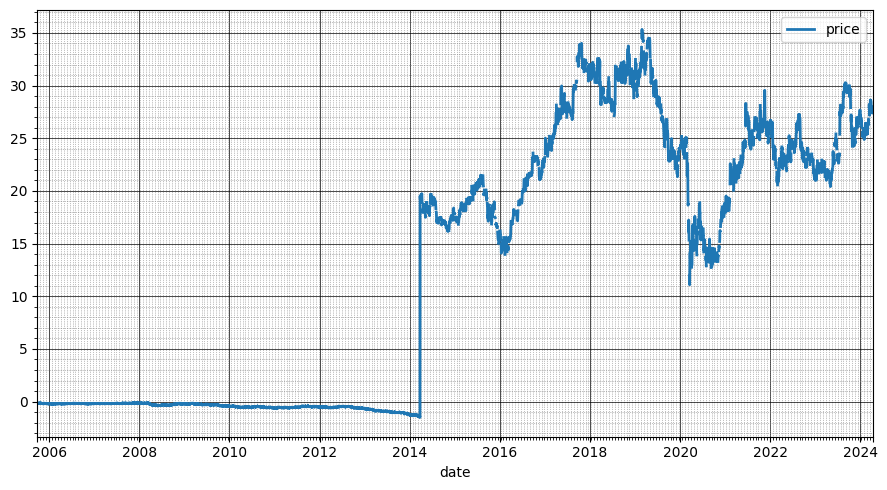

<Figure size 900x500 with 0 Axes>

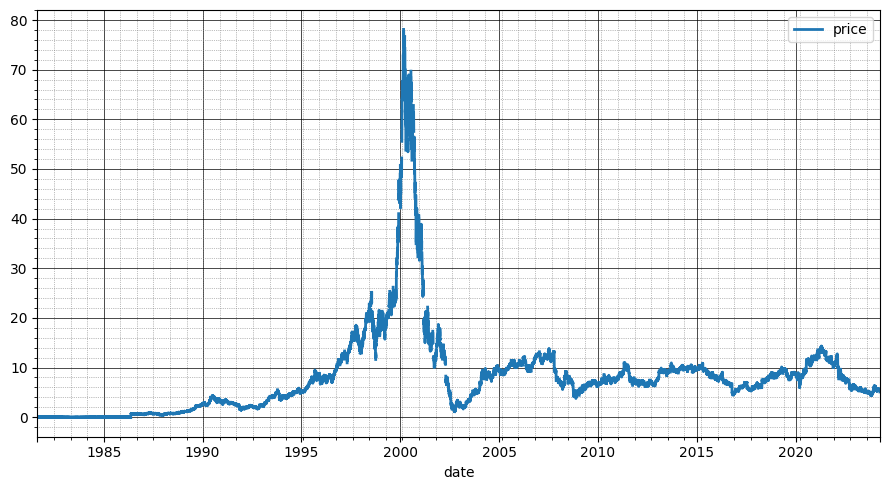

<Figure size 900x500 with 0 Axes>

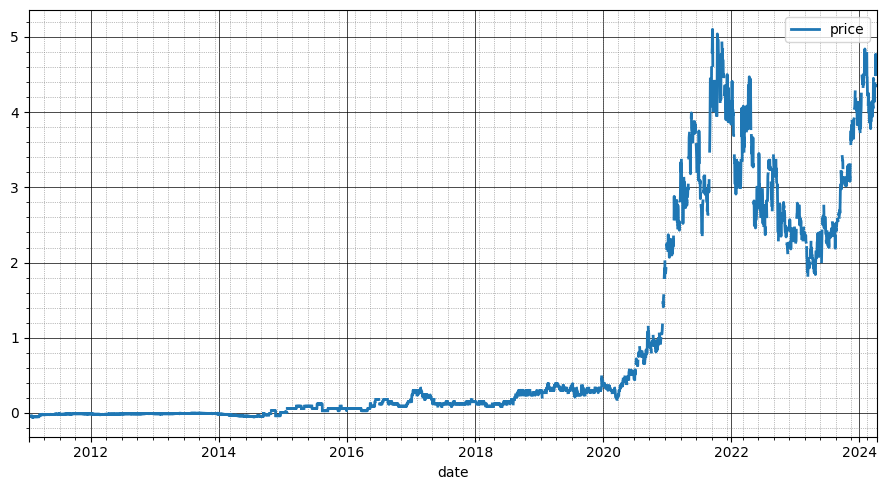

In [9]:
for symbol in symbols:
    sub = prices_full.filter(pl.col('symbol') == symbol).select(keys[0], 'price')
    plot_ts(sub, keys[0])

# Stocks with low coverage

In [10]:
prices.group_by('symbol').len().filter(pl.col('len') < 252 // 2).sort('len')

shape: (588, 2)
┌────────┬─────┐
│ symbol ┆ len │
│ ---    ┆ --- │
│ str    ┆ u32 │
╞════════╪═════╡
│ SNAXW  ┆ 1   │
│ GLSTW  ┆ 1   │
│ SVREW  ┆ 1   │
│ BFIIW  ┆ 1   │
│ SABSW  ┆ 1   │
│ …      ┆ …   │
│ WBUY   ┆ 118 │
│ ATPC   ┆ 124 │
│ FEPI   ┆ 124 │
│ NNAG   ┆ 125 │
│ GPAK   ┆ 125 │
└────────┴─────┘

# Coverages

<Figure size 900x500 with 0 Axes>

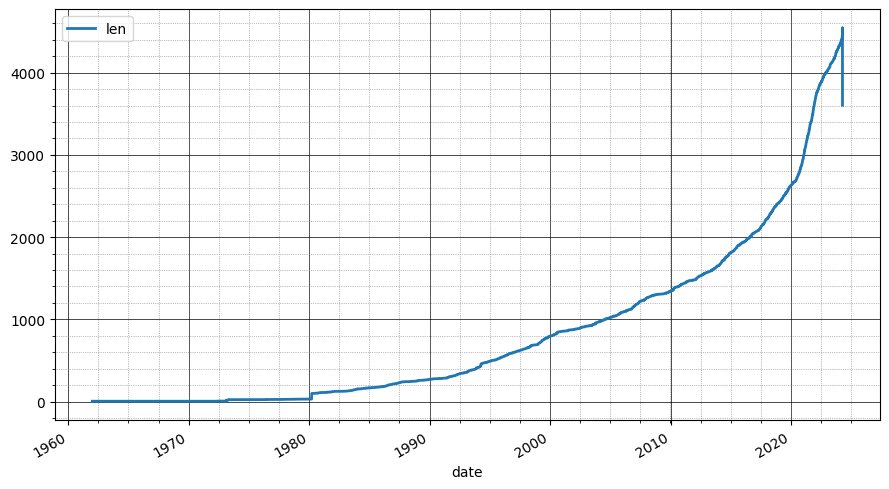

In [11]:
coverage = (
    prices
    .drop_nulls('price')
    .group_by('date', maintain_order=True)
    .len()
)
plot_ts(coverage, keys[0])

<Figure size 900x500 with 0 Axes>

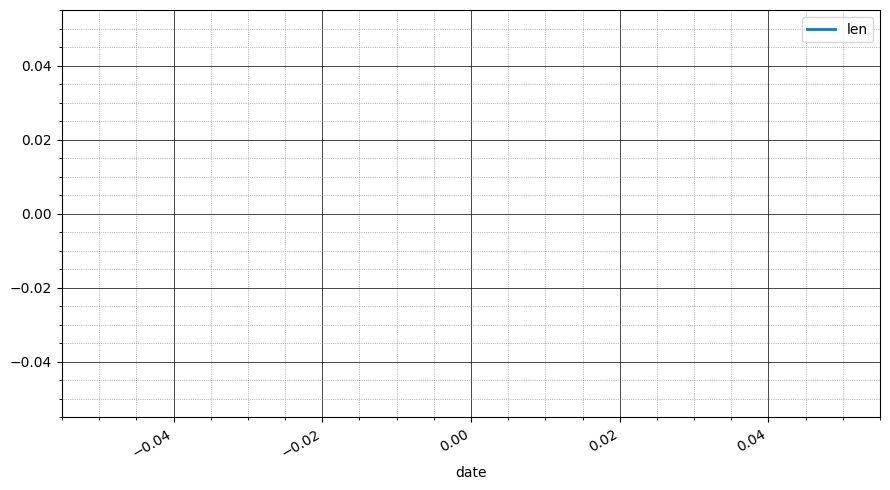

In [12]:
# on week_ends
coverage = (
    prices
    .drop_nulls('price')
    .filter(pl.col('date').dt.weekday().is_in([6, 7]))
    .group_by('date', maintain_order=True)
    .len()
)
plot_ts(coverage, keys[0])

<Figure size 900x500 with 0 Axes>

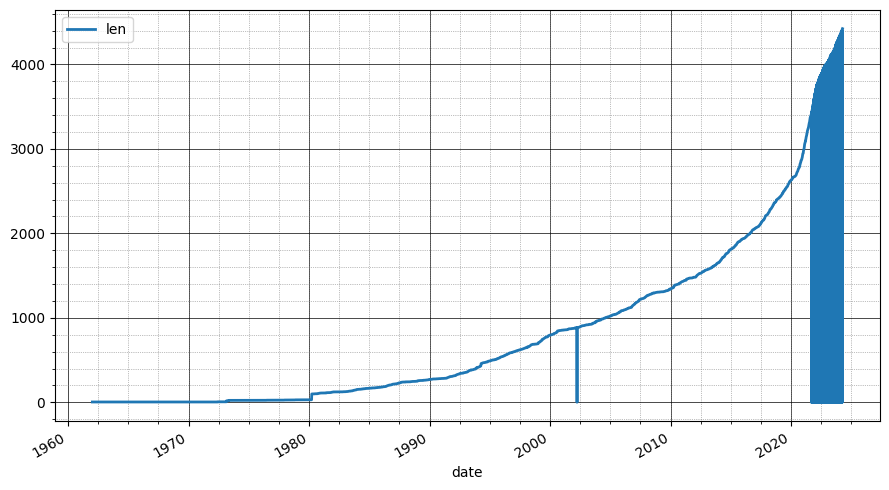

In [13]:
# dates without data for any stock
uncovered = (
    prices_full
    .filter(pl.col('price').is_null())
    .group_by('date')
    .len()
)
plot_ts(uncovered, keys[0])

In [14]:
attrs = ['len', 'n_unique', 'null_count']
(
    prices
    .group_by(weekday=pl.col('date').dt.weekday())
    .agg([
        getattr(pl.col('price'), attr)().alias(attr)
        for attr in attrs
    ])
    .sort('weekday')
)

shape: (5, 4)
┌─────────┬─────────┬──────────┬────────────┐
│ weekday ┆ len     ┆ n_unique ┆ null_count │
│ ---     ┆ ---     ┆ ---      ┆ ---        │
│ i8      ┆ u32     ┆ u32      ┆ u32        │
╞═════════╪═════════╪══════════╪════════════╡
│ 1       ┆ 2407274 ┆ 993321   ┆ 0          │
│ 2       ┆ 2645107 ┆ 1069592  ┆ 0          │
│ 3       ┆ 2645581 ┆ 1068958  ┆ 0          │
│ 4       ┆ 2600662 ┆ 1054299  ┆ 0          │
│ 5       ┆ 2580177 ┆ 1046765  ┆ 0          │
└─────────┴─────────┴──────────┴────────────┘

In [15]:
attrs = ['len', 'n_unique', 'null_count']
(
    prices_full
    .group_by(weekday=pl.col('date').dt.weekday())
    .agg([
        getattr(pl.col('price'), attr)().alias(attr)
        for attr in attrs
    ])
    .sort('weekday')
)

shape: (7, 4)
┌─────────┬─────────┬──────────┬────────────┐
│ weekday ┆ len     ┆ n_unique ┆ null_count │
│ ---     ┆ ---     ┆ ---      ┆ ---        │
│ i8      ┆ u32     ┆ u32      ┆ u32        │
╞═════════╪═════════╪══════════╪════════════╡
│ 1       ┆ 2671431 ┆ 993322   ┆ 264157     │
│ 2       ┆ 2671287 ┆ 1069593  ┆ 26180      │
│ 3       ┆ 2668641 ┆ 1068959  ┆ 23060      │
│ 4       ┆ 2669752 ┆ 1054300  ┆ 69090      │
│ 5       ┆ 2670789 ┆ 1046766  ┆ 90612      │
│ 6       ┆ 2670743 ┆ 1        ┆ 2670743    │
│ 7       ┆ 2670743 ┆ 1        ┆ 2670743    │
└─────────┴─────────┴──────────┴────────────┘

In [16]:
attrs = ['len', 'n_unique', 'null_count']
(
    prices_wo_weekends
    .group_by(weekday=pl.col('date').dt.weekday())
    .agg([
        getattr(pl.col('price'), attr)().alias(attr)
        for attr in attrs
    ])
    .sort('weekday')
)

shape: (5, 4)
┌─────────┬─────────┬──────────┬────────────┐
│ weekday ┆ len     ┆ n_unique ┆ null_count │
│ ---     ┆ ---     ┆ ---      ┆ ---        │
│ i8      ┆ u32     ┆ u32      ┆ u32        │
╞═════════╪═════════╪══════════╪════════════╡
│ 1       ┆ 2671431 ┆ 993322   ┆ 264157     │
│ 2       ┆ 2671287 ┆ 1069593  ┆ 26180      │
│ 3       ┆ 2668641 ┆ 1068959  ┆ 23060      │
│ 4       ┆ 2669752 ┆ 1054300  ┆ 69090      │
│ 5       ┆ 2670789 ┆ 1046766  ┆ 90612      │
└─────────┴─────────┴──────────┴────────────┘

# Summary

## Previous cleaning

In [17]:
prices = (
    pl.scan_parquet('yf/yf.parquet')
    .rename({'Date' : keys[0], 'Symbol': keys[1], 'Adj Close': 'price', 'Volume': 'volume'})
    .select(*keys, 'price', 'volume')
    .collect()
)
prices = cast_to_date(prices, keys[0])
assert prices.null_count().sum_horizontal().item() == 0
# prices.write_parquet('prices_n_volumes.parquet')

In [18]:
min_n_points = 252
max_null_prop = 0.02

null_prop = pl.col('price').null_count() / pl.len()

cleaner = prices

full_index_per_symbol = get_full_index_per_symbol(fold(cleaner, *keys), *keys)
cleaner = full_index_per_symbol.join(cleaner, how='left', on=keys)

cleaner = (
    cleaner
    .filter(pl.col('price').is_null().all().not_().over(keys[0]))
    .filter((pl.col('price') >= 0).all().over(keys[1]))
    .filter(pl.col('price').is_null().not_().sum().over(keys[1]) >= min_n_points)
)
cleaner.null_count()

shape: (1, 4)
┌──────┬────────┬───────┬────────┐
│ date ┆ symbol ┆ price ┆ volume │
│ ---  ┆ ---    ┆ ---   ┆ ---    │
│ u32  ┆ u32    ┆ u32   ┆ u32    │
╞══════╪════════╪═══════╪════════╡
│ 0    ┆ 0      ┆ 133   ┆ 133    │
└──────┴────────┴───────┴────────┘

In [19]:
cleaner.select(pl.col('date').n_unique(), pl.col('symbol').n_unique())

shape: (1, 2)
┌───────┬────────┐
│ date  ┆ symbol │
│ ---   ┆ ---    │
│ u32   ┆ u32    │
╞═══════╪════════╡
│ 15674 ┆ 4098   │
└───────┴────────┘

In [20]:
cleaner_wo_weekends = (
    cleaner
    .filter(pl.col('date').dt.weekday().is_in([6, 7]).not_())
)
cleaner_wo_weekends.null_count()

shape: (1, 4)
┌──────┬────────┬───────┬────────┐
│ date ┆ symbol ┆ price ┆ volume │
│ ---  ┆ ---    ┆ ---   ┆ ---    │
│ u32  ┆ u32    ┆ u32   ┆ u32    │
╞══════╪════════╪═══════╪════════╡
│ 0    ┆ 0      ┆ 133   ┆ 133    │
└──────┴────────┴───────┴────────┘

In [21]:
cleaner_wo_weekends.select(pl.col('date').n_unique(), pl.col('symbol').n_unique())

shape: (1, 2)
┌───────┬────────┐
│ date  ┆ symbol │
│ ---   ┆ ---    │
│ u32   ┆ u32    │
╞═══════╪════════╡
│ 15674 ┆ 4098   │
└───────┴────────┘

## Cleaning based on null_prop

In [22]:
null_props = (
    cleaner_wo_weekends
    .group_by('symbol')
    .agg(null_prop=null_prop)
    .sort('null_prop')
)
null_props.describe(percentiles=(0.95, 0.9, 0.8, 0.7, 0.6, 0.55, 0.5))

shape: (13, 3)
┌────────────┬────────┬───────────┐
│ statistic  ┆ symbol ┆ null_prop │
│ ---        ┆ ---    ┆ ---       │
│ str        ┆ str    ┆ f64       │
╞════════════╪════════╪═══════════╡
│ count      ┆ 4098   ┆ 4098.0    │
│ null_count ┆ 0      ┆ 0.0       │
│ mean       ┆ null   ┆ 0.000038  │
│ std        ┆ null   ┆ 0.001019  │
│ min        ┆ AACG   ┆ 0.0       │
│ …          ┆ …      ┆ …         │
│ 70%        ┆ null   ┆ 0.0       │
│ 80%        ┆ null   ┆ 0.0       │
│ 90%        ┆ null   ┆ 0.0       │
│ 95%        ┆ null   ┆ 0.0       │
│ max        ┆ ZYXI   ┆ 0.035382  │
└────────────┴────────┴───────────┘

array([[<Axes: title={'center': 'null_prop'}>]], dtype=object)

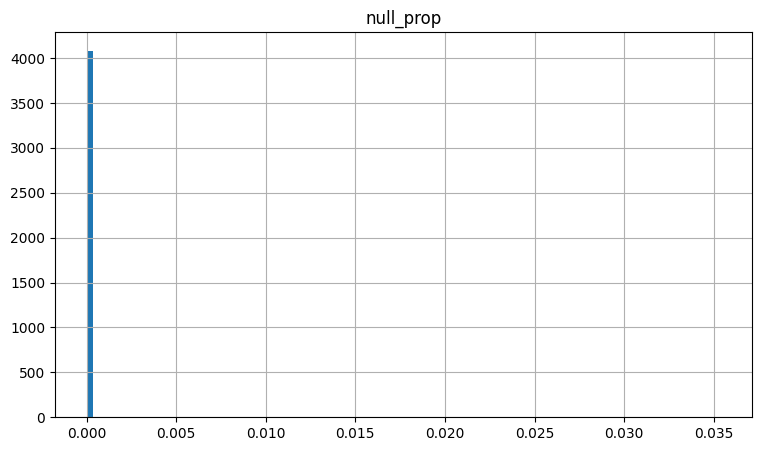

In [23]:
null_props.to_pandas().set_index('symbol').hist(bins=100)

array([[<Axes: title={'center': 'null_prop'}>]], dtype=object)

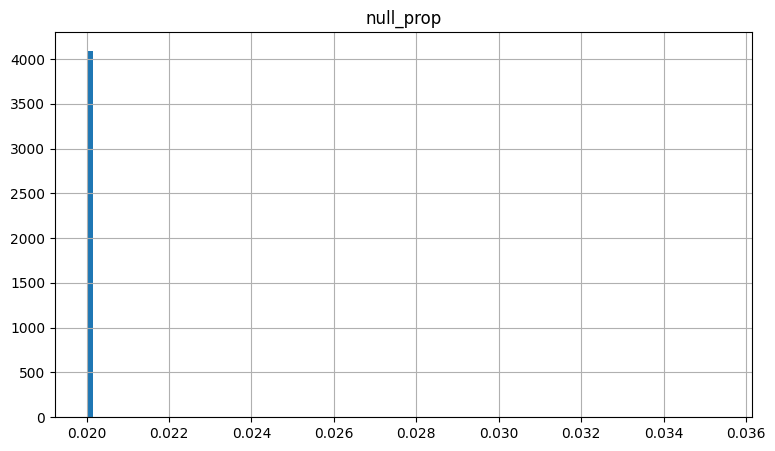

In [24]:
null_props.to_pandas().set_index('symbol').clip(max_null_prop).hist(bins=100)

In [25]:
cleaner_wo_weekends = (
    cleaner_wo_weekends
    .filter(null_prop.over(keys[1]) <= 0.02)
)

RENB


<Figure size 900x500 with 0 Axes>

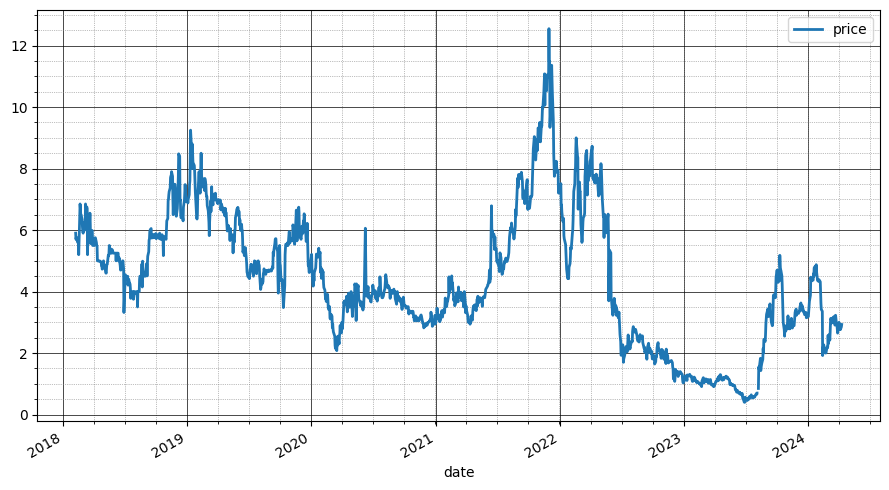

****************************************************************************************************
ELVN


<Figure size 900x500 with 0 Axes>

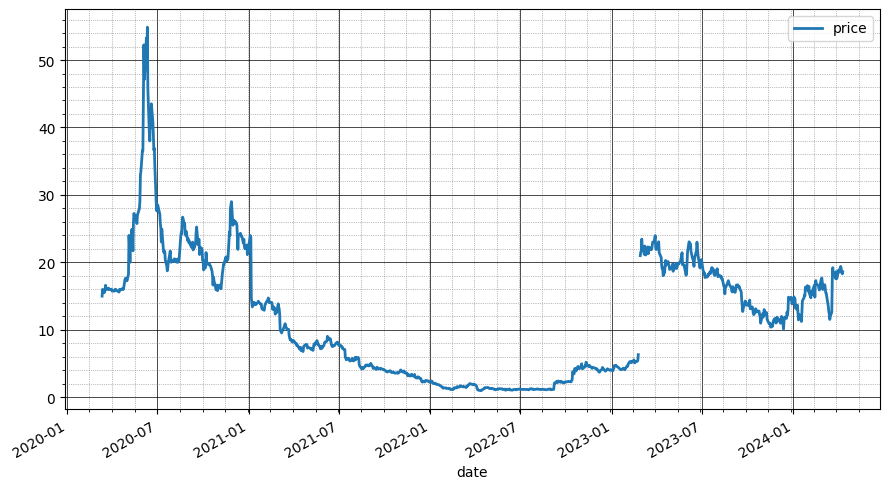

****************************************************************************************************
PMGMU


<Figure size 900x500 with 0 Axes>

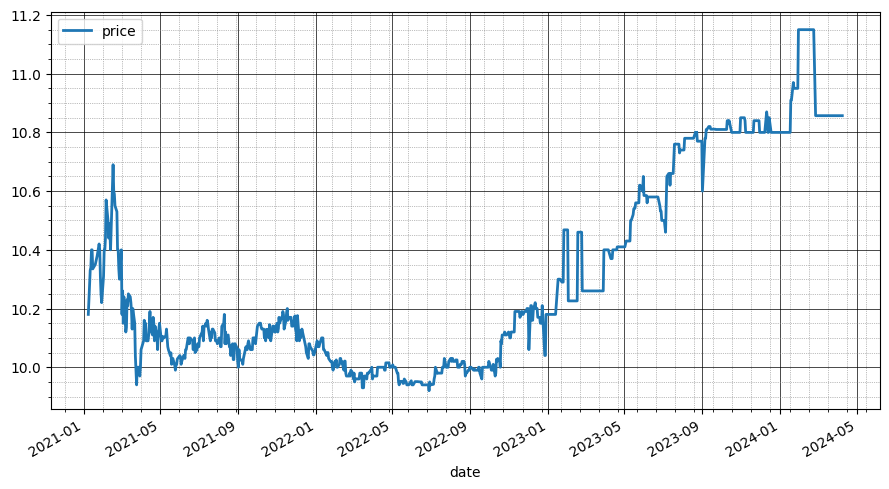

****************************************************************************************************
TLSI


<Figure size 900x500 with 0 Axes>

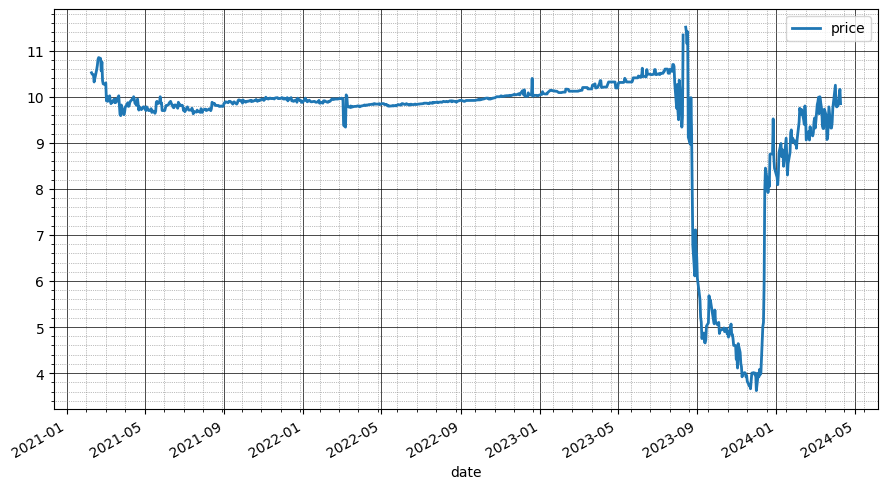

****************************************************************************************************
TYGO


<Figure size 900x500 with 0 Axes>

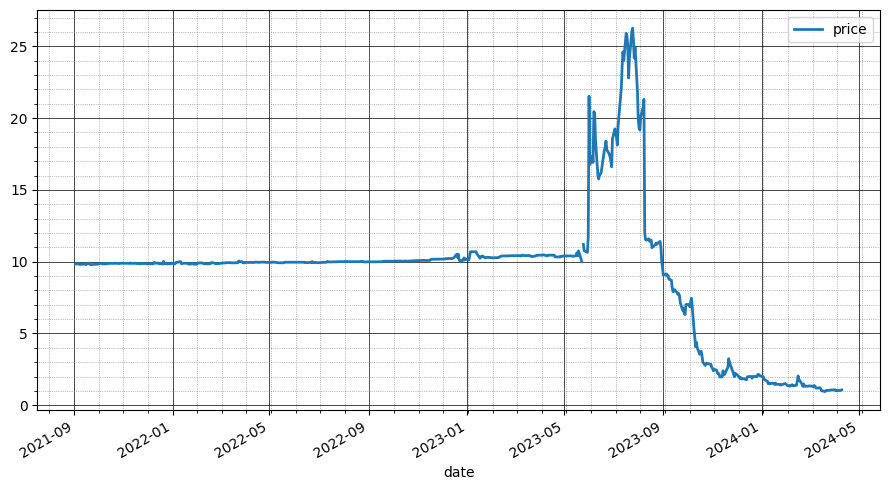

****************************************************************************************************
JTAI


<Figure size 900x500 with 0 Axes>

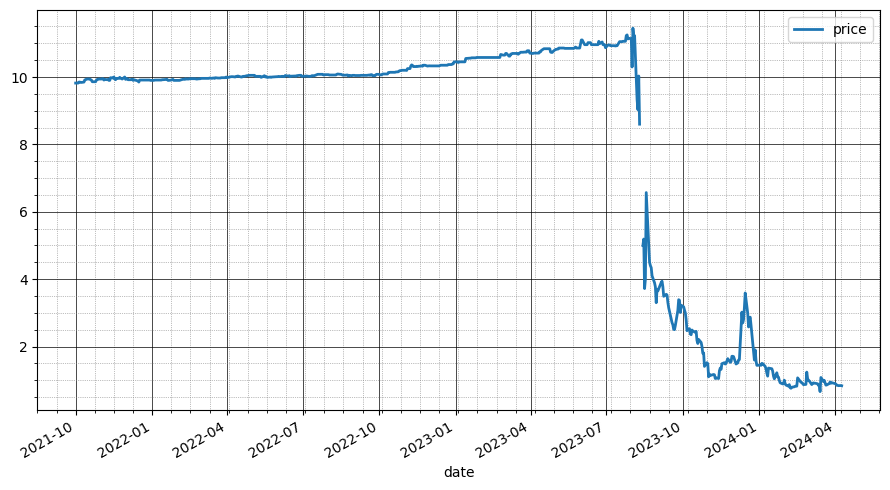

****************************************************************************************************
ESGL


<Figure size 900x500 with 0 Axes>

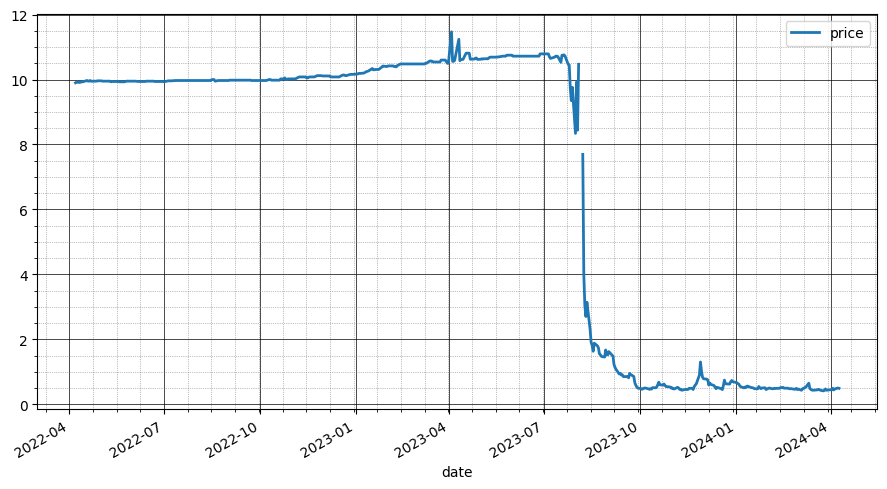

****************************************************************************************************
LUXH


<Figure size 900x500 with 0 Axes>

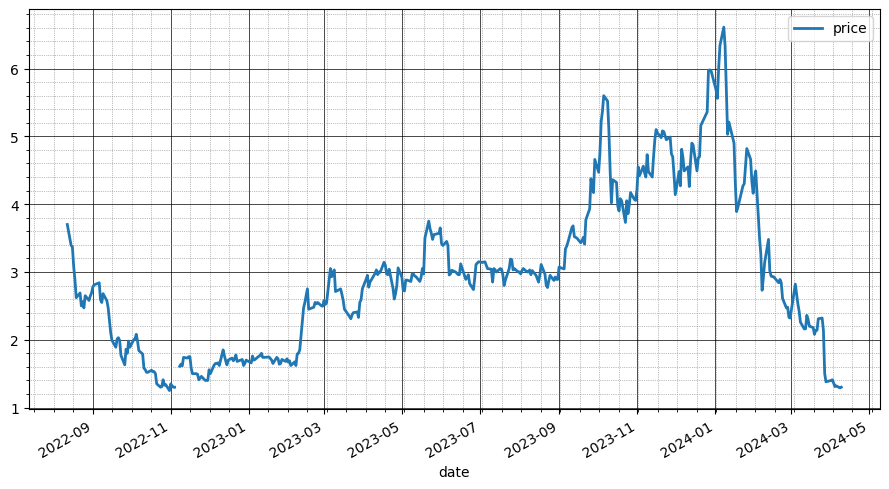

****************************************************************************************************
CRVO


<Figure size 900x500 with 0 Axes>

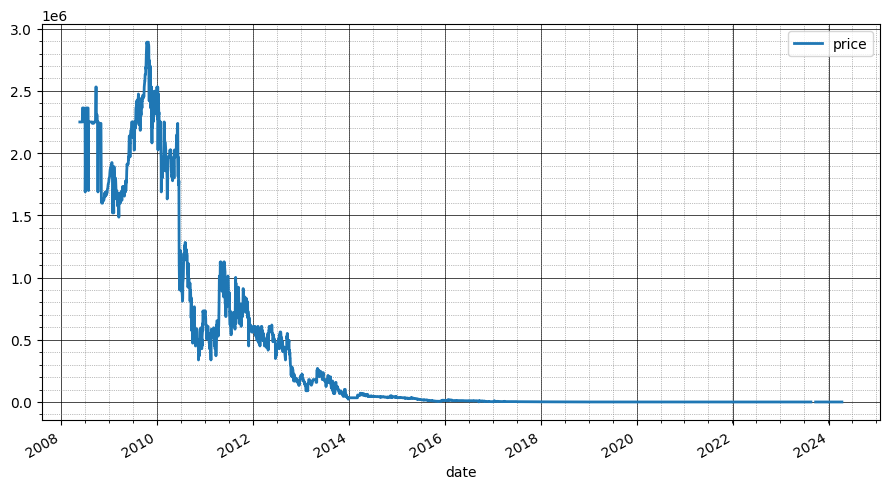

****************************************************************************************************
NUKK


<Figure size 900x500 with 0 Axes>

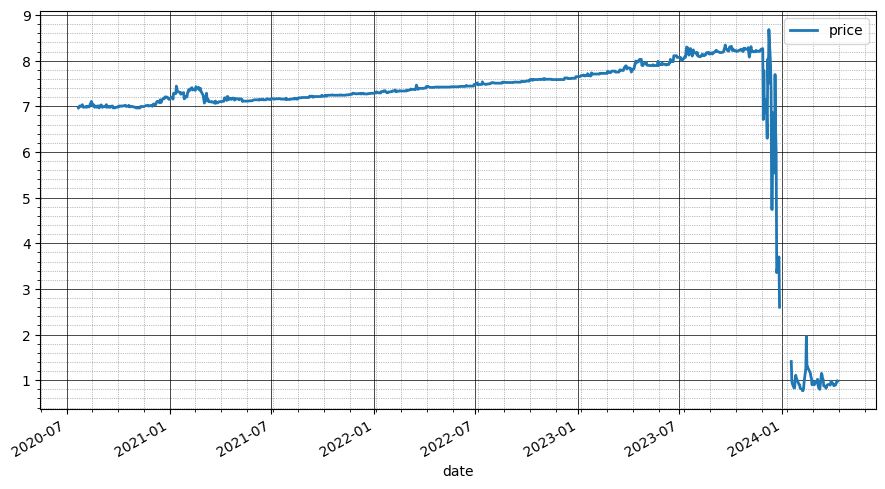

****************************************************************************************************


In [26]:
worst = (
    cleaner_wo_weekends
    .with_columns(null_prop=null_prop.over(keys[1]))
    .sort('null_prop', 'symbol', 'date')
)
for symbol in worst.get_column('symbol').unique(maintain_order=True).tail(10):
    print(symbol)
    sub = cleaner_wo_weekends.filter(pl.col('symbol') == symbol).select(keys[0], 'price')
    plot_ts(sub, keys[0])
    print('*' * 100)

## Plot stocks with most variant demeaned price

In [27]:
variances = (
    cleaner_wo_weekends
    .with_columns(mean=pl.col('price').rolling_mean(window_size=225 // 12).over(keys[1]))
    .with_columns(pl.col('price') - pl.col('mean'))
    .group_by(keys[1])
    .agg(variance=pl.col('price').std())
    .sort('variance')
)
variances.describe()

shape: (9, 3)
┌────────────┬────────┬───────────┐
│ statistic  ┆ symbol ┆ variance  │
│ ---        ┆ ---    ┆ ---       │
│ str        ┆ str    ┆ f64       │
╞════════════╪════════╪═══════════╡
│ count      ┆ 4094   ┆ 4094.0    │
│ null_count ┆ 0      ┆ 0.0       │
│ mean       ┆ null   ┆ 5.0193e9  │
│ std        ┆ null   ┆ 3.2103e11 │
│ min        ┆ AACG   ┆ 0.0       │
│ 25%        ┆ null   ┆ 0.558828  │
│ 50%        ┆ null   ┆ 1.136962  │
│ 75%        ┆ null   ┆ 3.020847  │
│ max        ┆ ZYXI   ┆ 2.0541e13 │
└────────────┴────────┴───────────┘

In [28]:
high_variances = (
    variances
    .filter((pl.col('variance') > 2) | pl.col('variance').is_null())
)
len(high_variances)

1378

<Figure size 900x500 with 0 Axes>

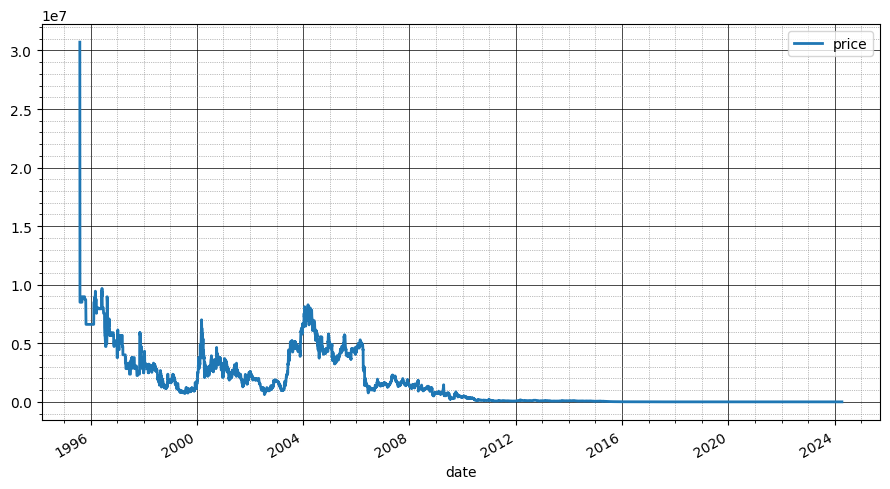

<Figure size 900x500 with 0 Axes>

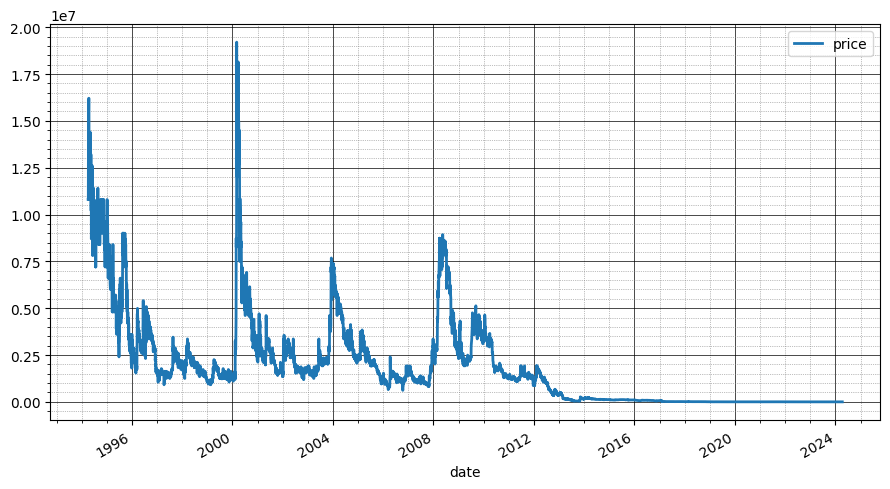

<Figure size 900x500 with 0 Axes>

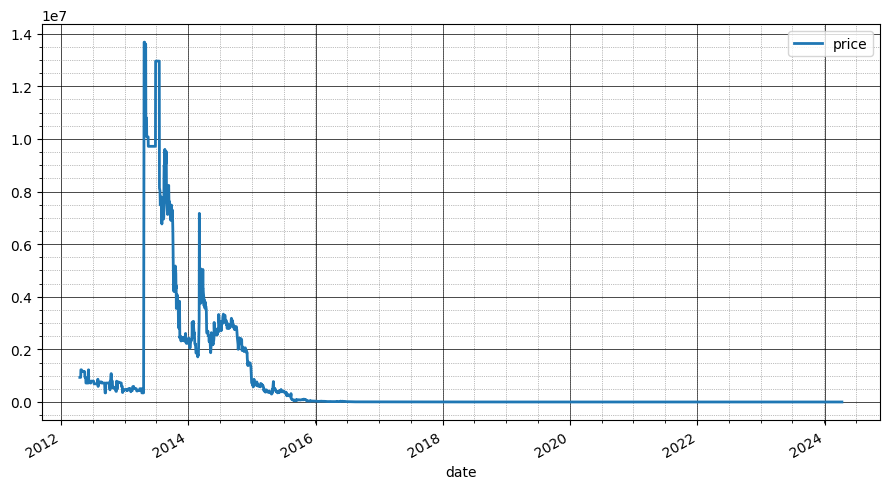

<Figure size 900x500 with 0 Axes>

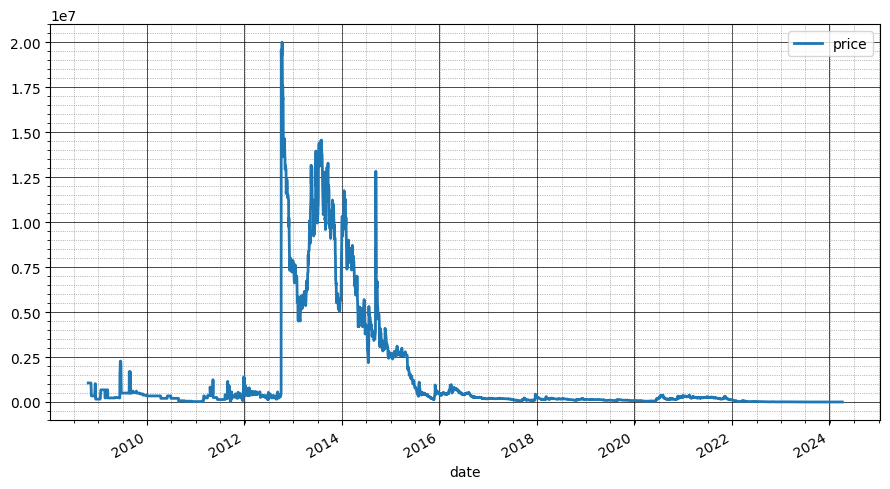

<Figure size 900x500 with 0 Axes>

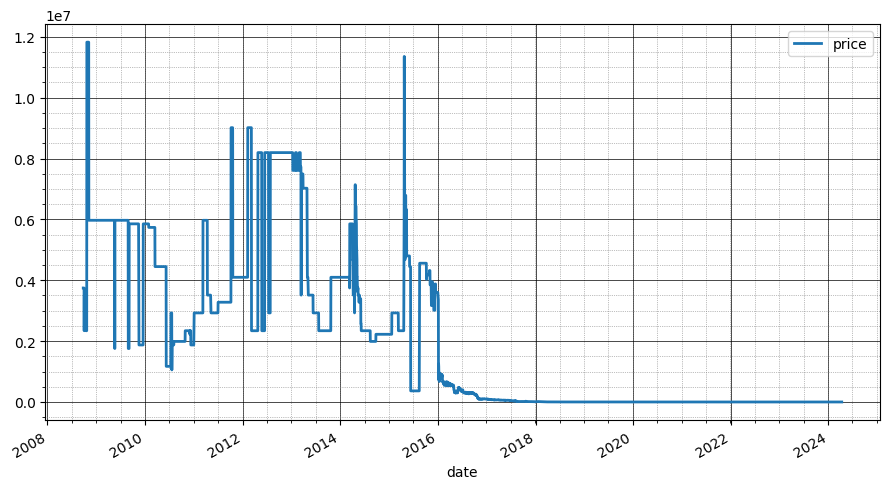

<Figure size 900x500 with 0 Axes>

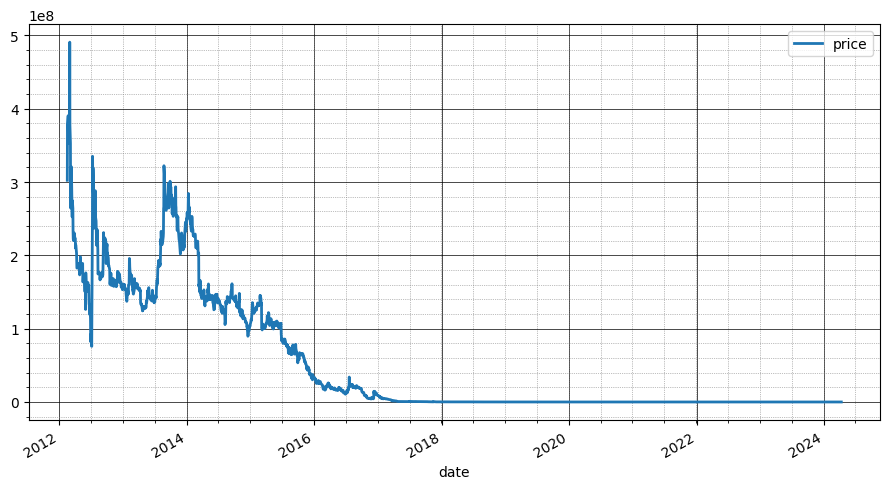

<Figure size 900x500 with 0 Axes>

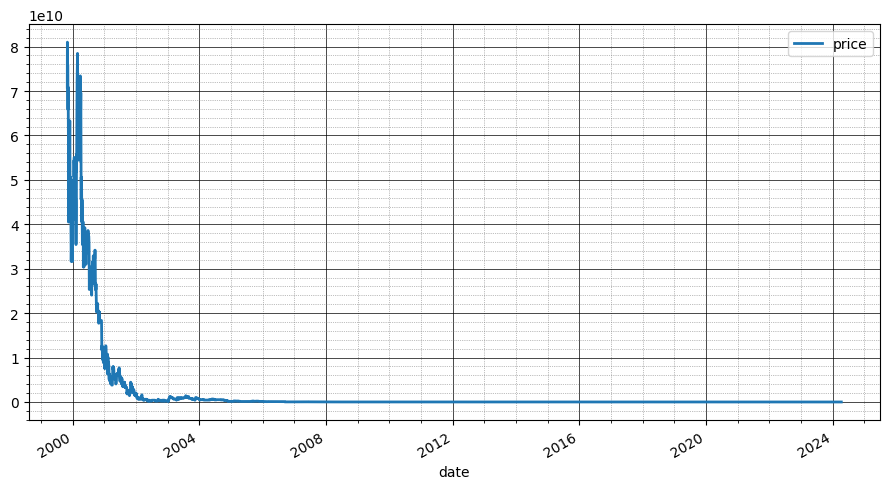

<Figure size 900x500 with 0 Axes>

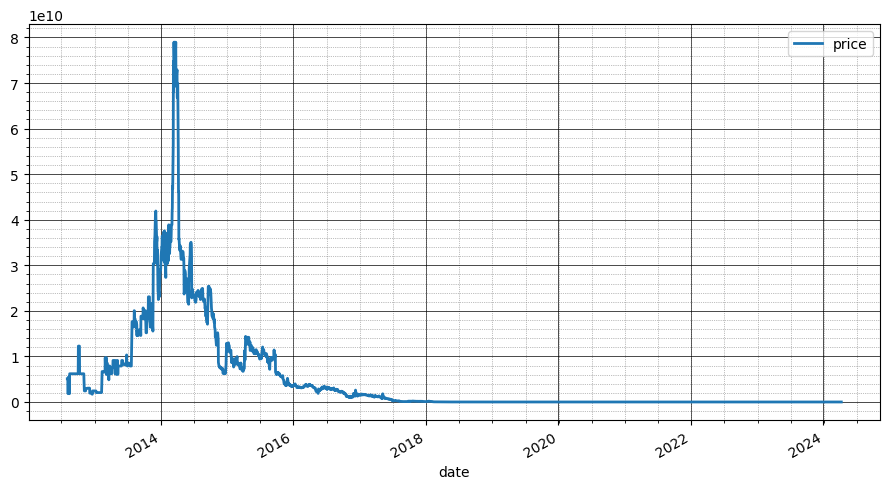

<Figure size 900x500 with 0 Axes>

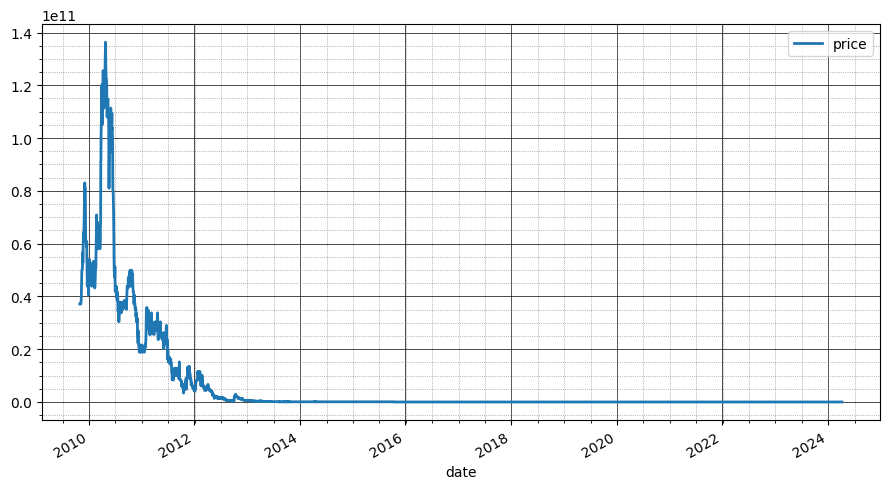

<Figure size 900x500 with 0 Axes>

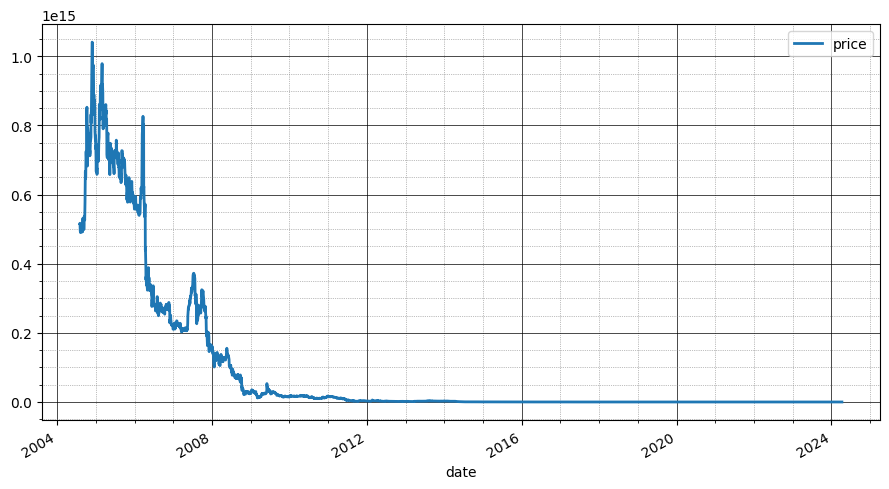

In [29]:
for symbol in high_variances.tail(10).get_column(keys[1]):
    sub = cleaner_wo_weekends.filter(pl.col(keys[1]) == symbol).select(keys[0], 'price')
    plot_ts(sub, keys[0])

<Figure size 900x500 with 0 Axes>

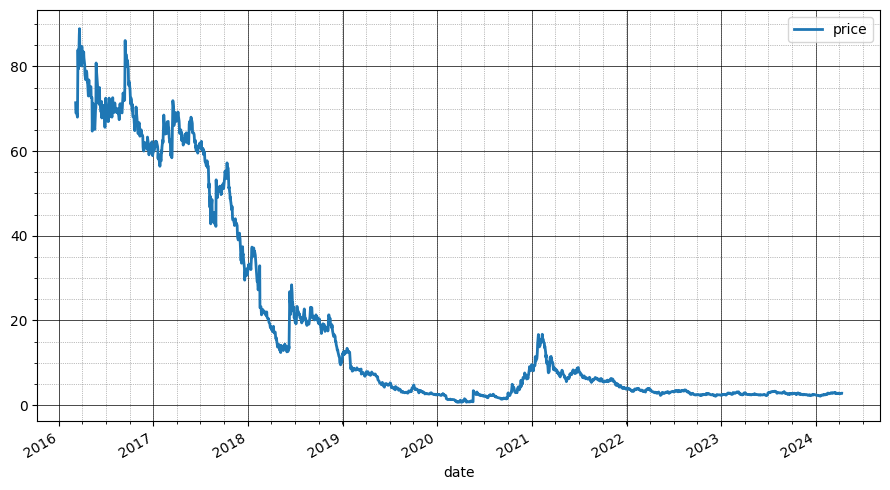

<Figure size 900x500 with 0 Axes>

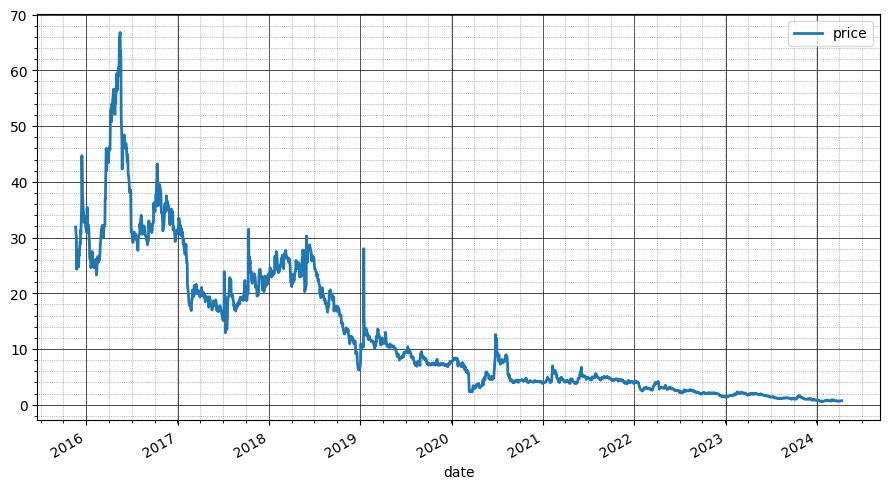

<Figure size 900x500 with 0 Axes>

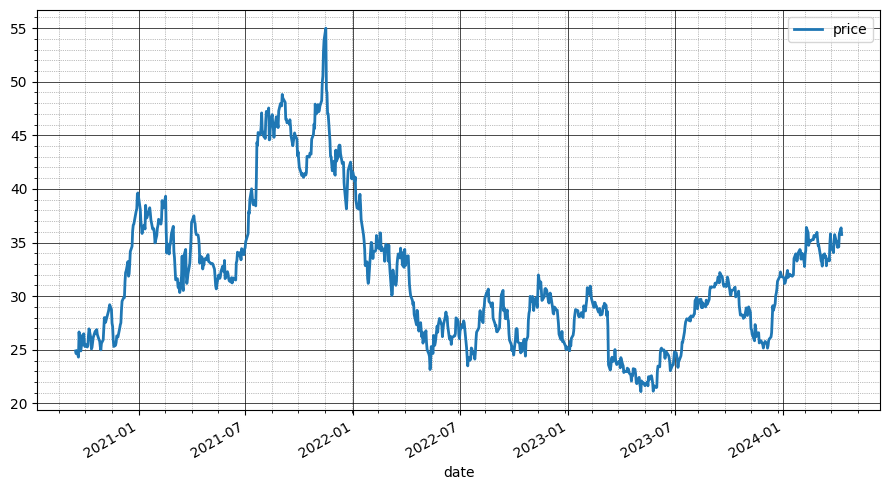

<Figure size 900x500 with 0 Axes>

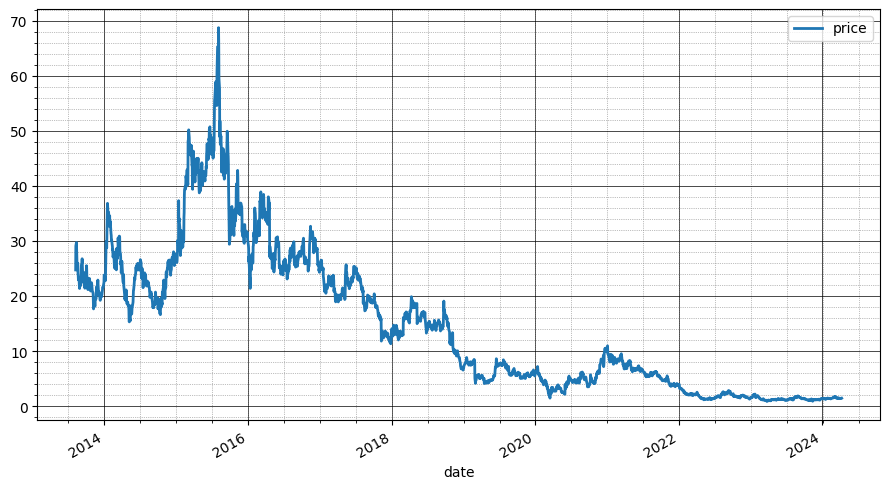

<Figure size 900x500 with 0 Axes>

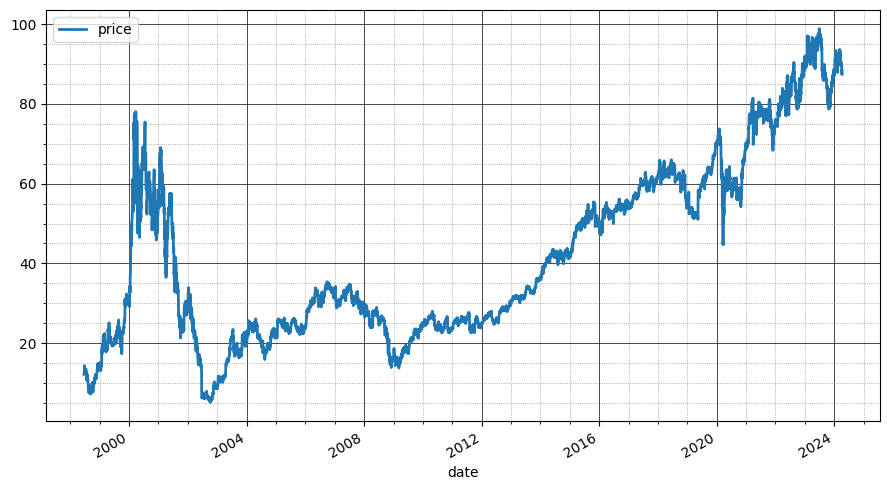

<Figure size 900x500 with 0 Axes>

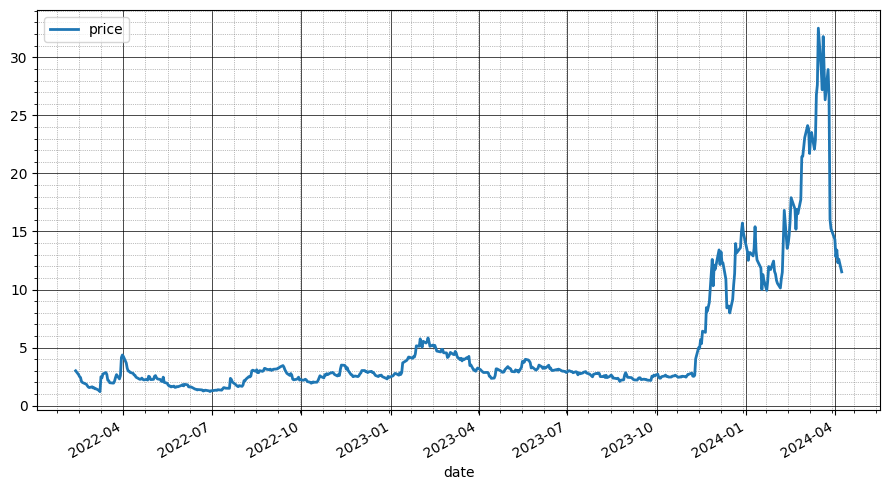

<Figure size 900x500 with 0 Axes>

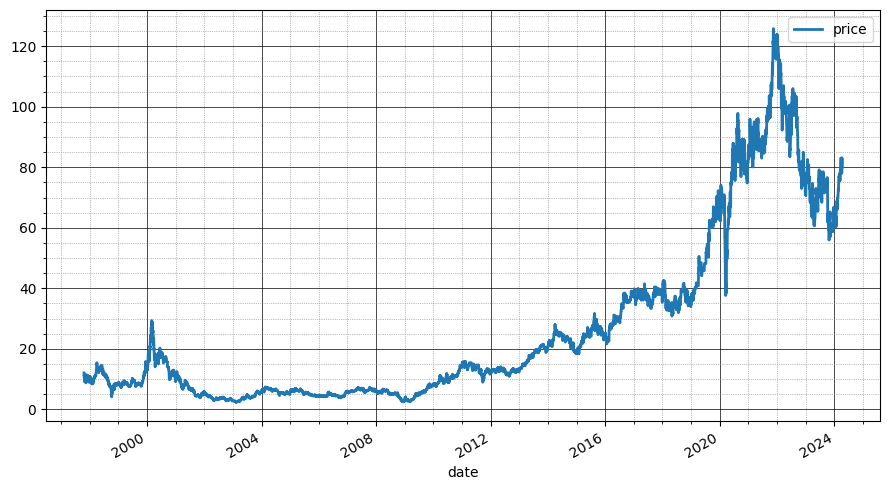

<Figure size 900x500 with 0 Axes>

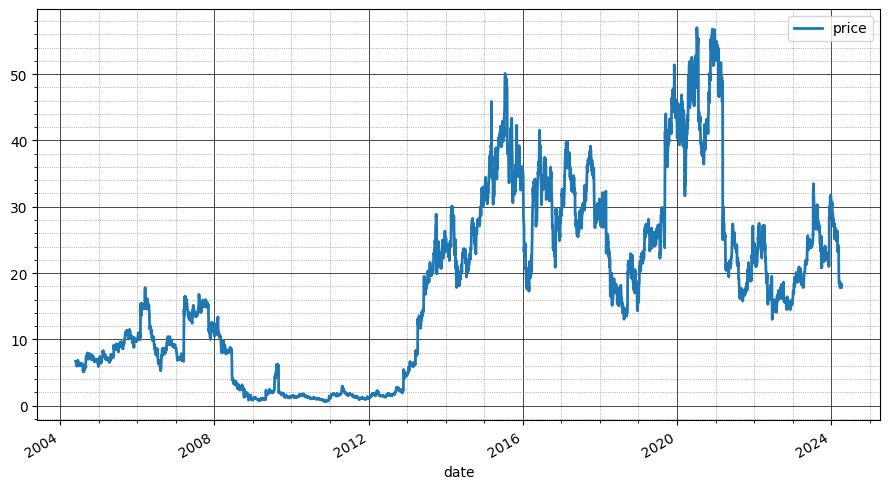

<Figure size 900x500 with 0 Axes>

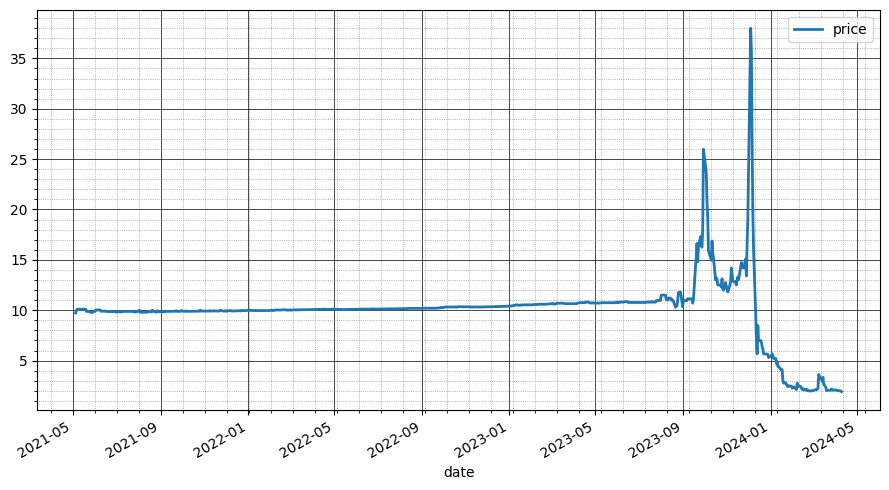

<Figure size 900x500 with 0 Axes>

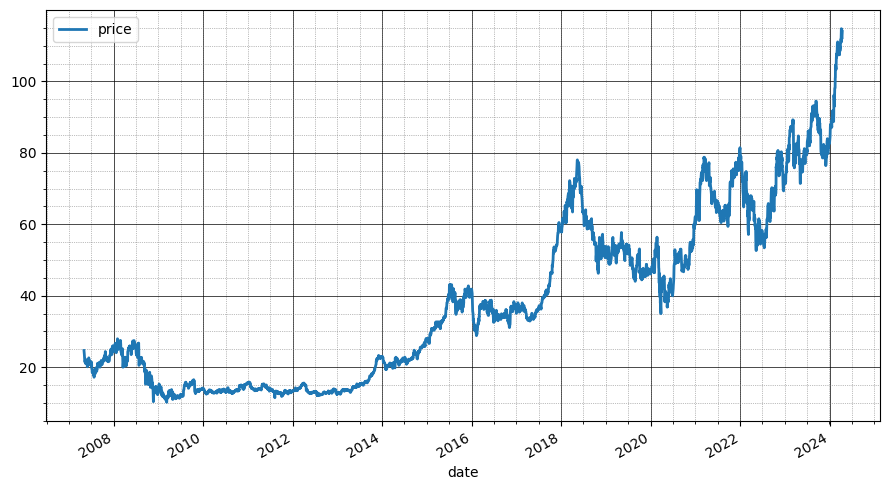

In [30]:
for symbol in high_variances.head(10).get_column(keys[1]):
    sub = cleaner_wo_weekends.filter(pl.col(keys[1]) == symbol).select(keys[0], 'price')
    plot_ts(sub, keys[0])

## Returns

In [31]:
returns = (
    cleaner_wo_weekends
    .select(*keys, pl.col('price').pct_change().over(keys[1]).alias('return'))
)
returns.describe()

shape: (9, 4)
┌────────────┬────────────┬──────────┬─────────────┐
│ statistic  ┆ date       ┆ symbol   ┆ return      │
│ ---        ┆ ---        ┆ ---      ┆ ---         │
│ str        ┆ str        ┆ str      ┆ f64         │
╞════════════╪════════════╪══════════╪═════════════╡
│ count      ┆ 12819980   ┆ 12819980 ┆ 1.2815886e7 │
│ null_count ┆ 0          ┆ 0        ┆ 4094.0      │
│ mean       ┆ 2012-06-01 ┆ null     ┆ 0.001983    │
│ std        ┆ null       ┆ null     ┆ 1.476912    │
│ min        ┆ 1962-01-02 ┆ AACG     ┆ -0.9998     │
│ 25%        ┆ 2006-04-25 ┆ null     ┆ -0.012657   │
│ 50%        ┆ 2015-03-31 ┆ null     ┆ 0.0         │
│ 75%        ┆ 2020-11-10 ┆ null     ┆ 0.011878    │
│ max        ┆ 2024-04-09 ┆ ZYXI     ┆ 4165.667189 │
└────────────┴────────────┴──────────┴─────────────┘

In [32]:
high_returns = (
    returns
    .filter(pl.col('return').abs() > 0.5)
    .group_by(keys[1])
    .agg(pl.col('return').abs().max())
    .sort(pl.col('return').abs())
)
len(high_returns)

1670

<Figure size 900x500 with 0 Axes>

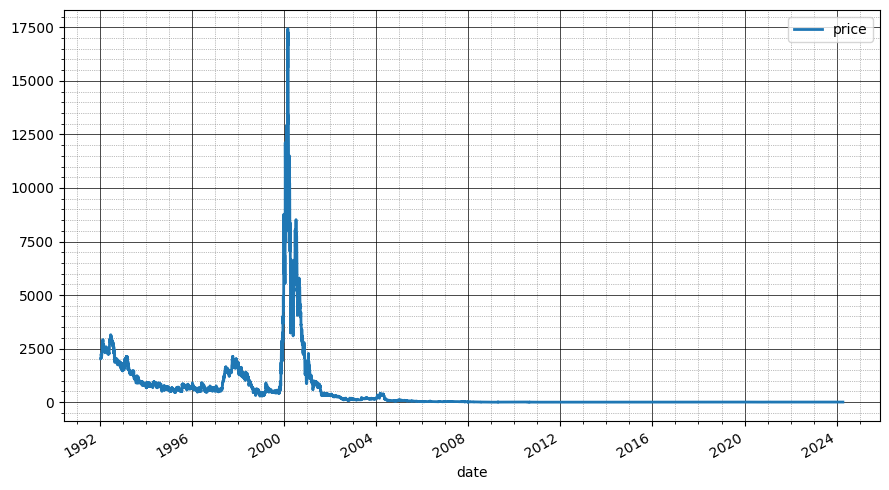

<Figure size 900x500 with 0 Axes>

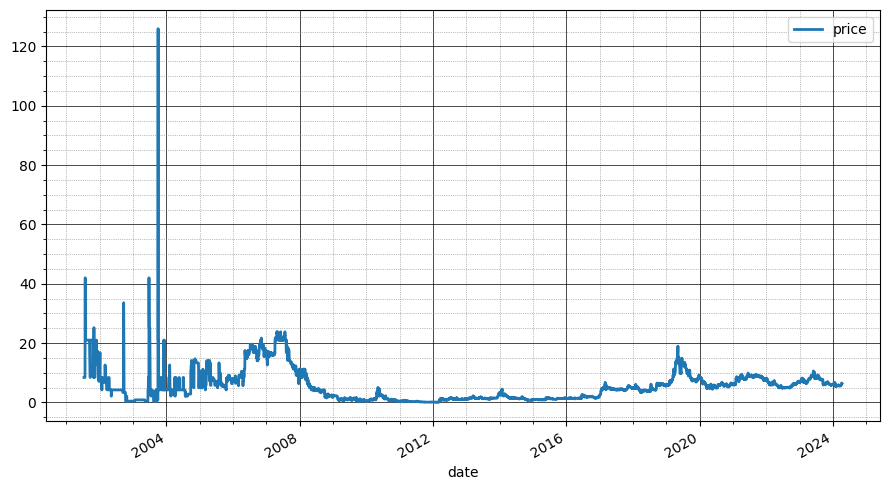

<Figure size 900x500 with 0 Axes>

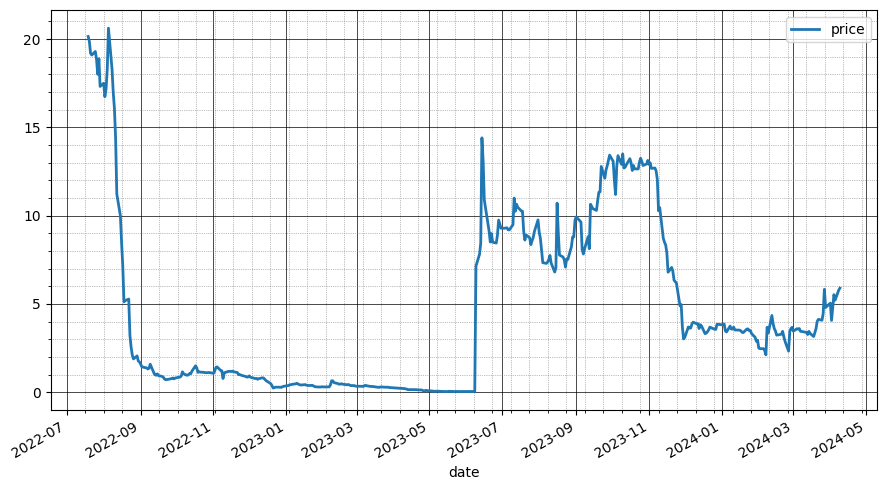

<Figure size 900x500 with 0 Axes>

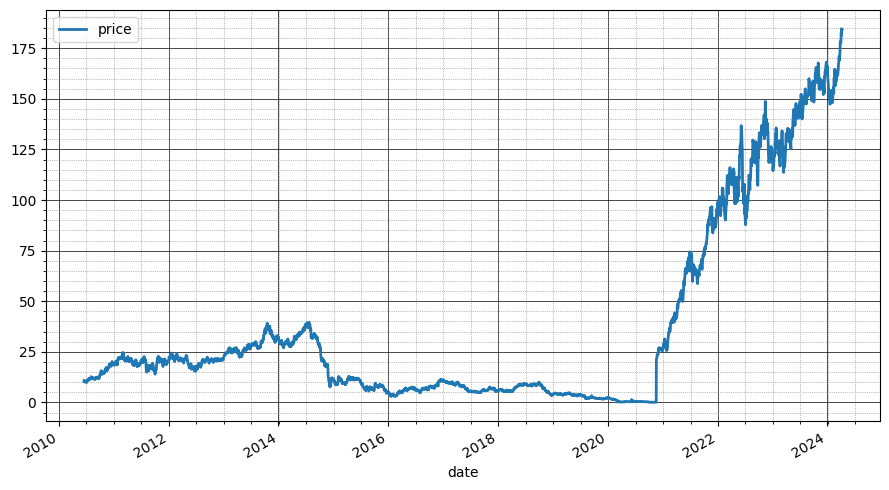

<Figure size 900x500 with 0 Axes>

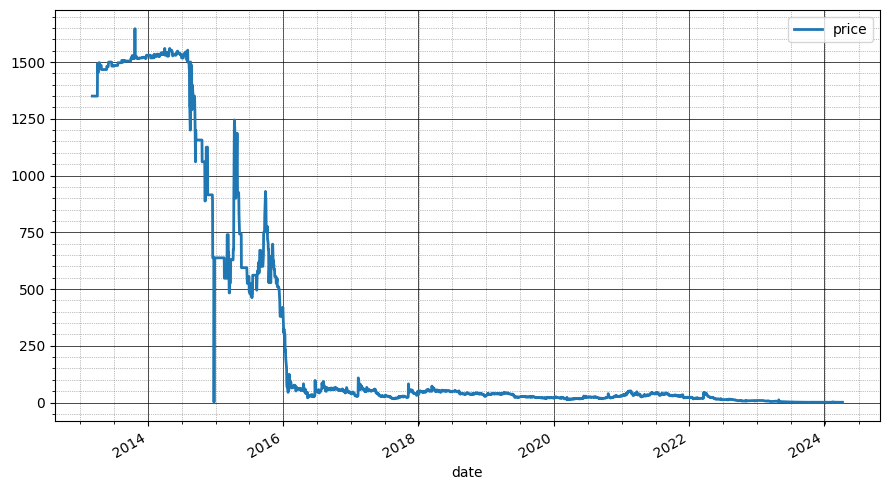

<Figure size 900x500 with 0 Axes>

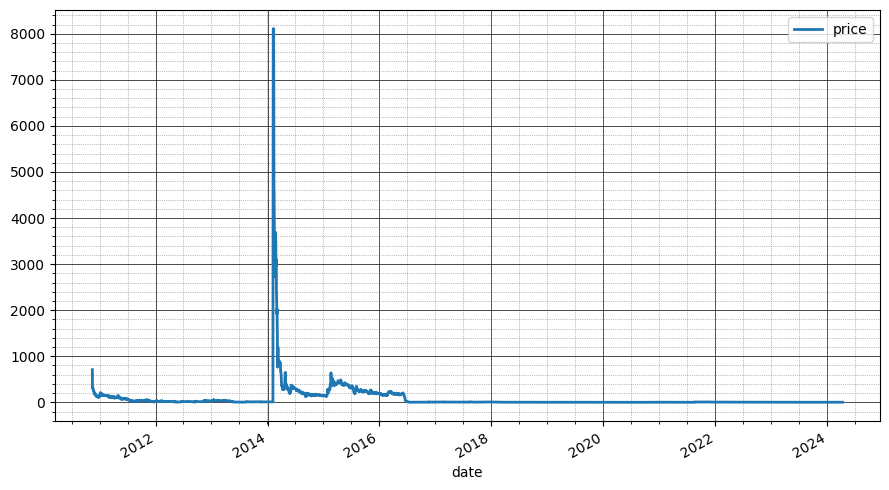

<Figure size 900x500 with 0 Axes>

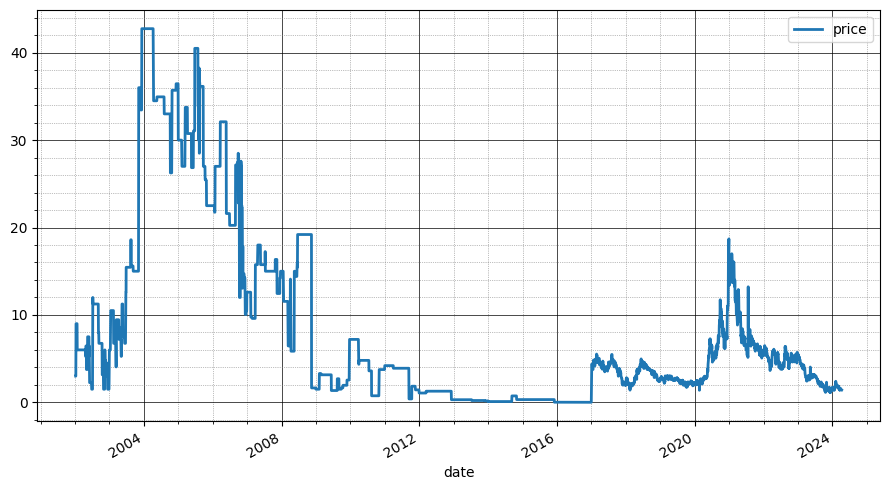

<Figure size 900x500 with 0 Axes>

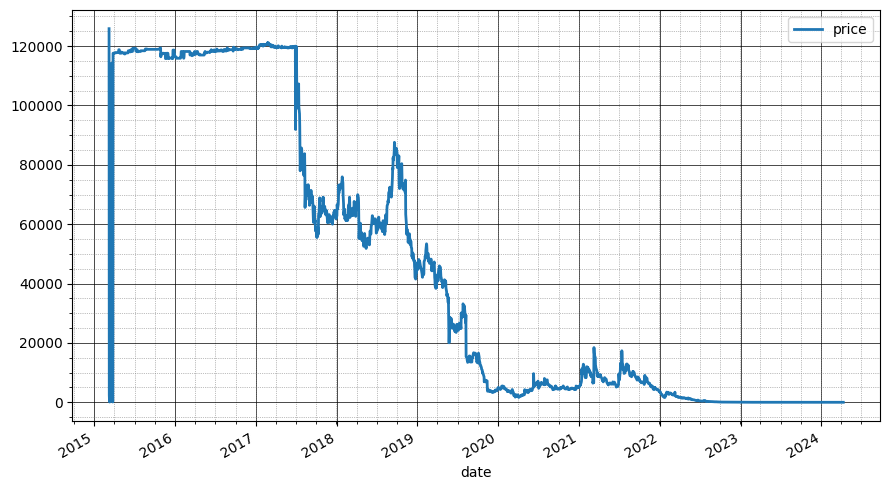

<Figure size 900x500 with 0 Axes>

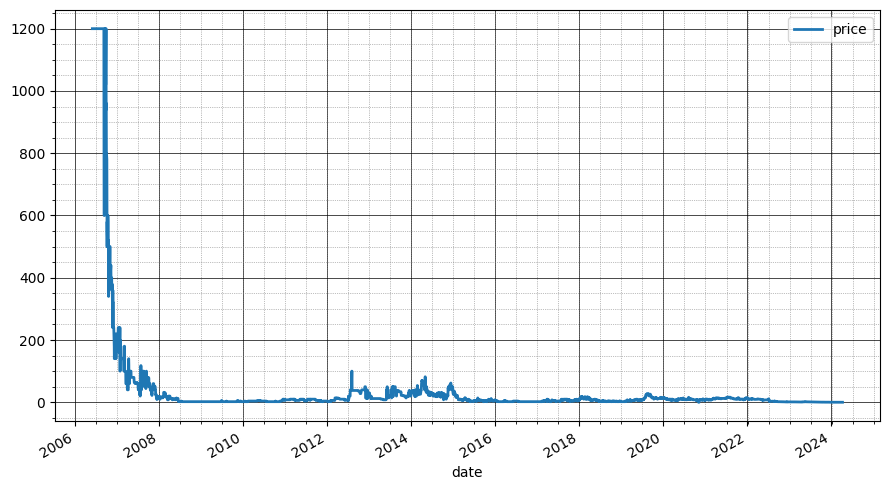

<Figure size 900x500 with 0 Axes>

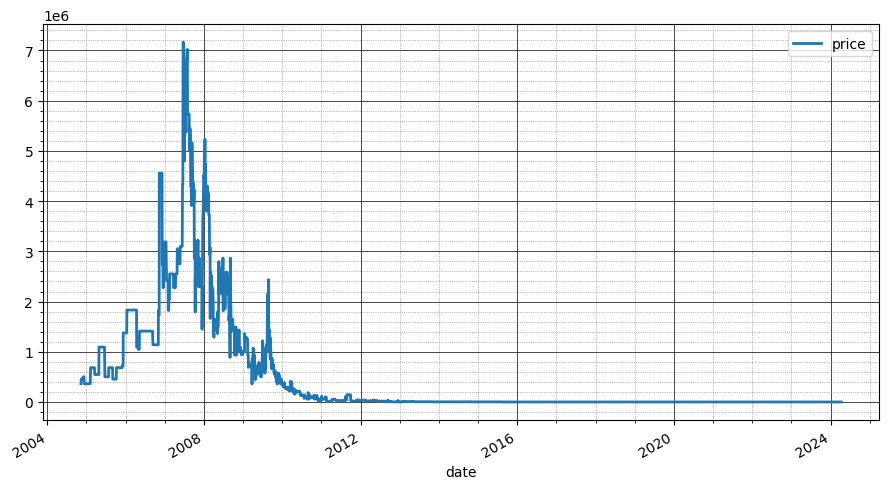

In [33]:
for symbol in high_returns.tail(10).get_column(keys[1]):
    sub = cleaner_wo_weekends.filter(pl.col(keys[1]) == symbol).select(keys[0], 'price')
    plot_ts(sub, keys[0])

<Figure size 900x500 with 0 Axes>

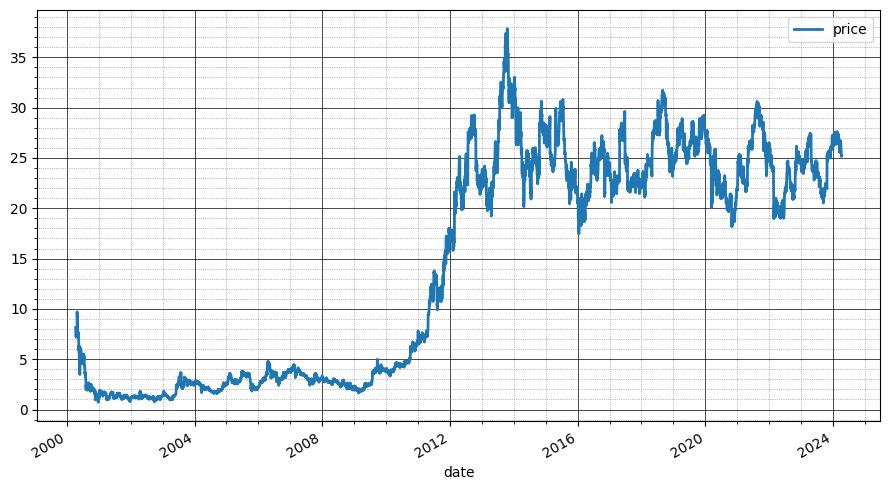

<Figure size 900x500 with 0 Axes>

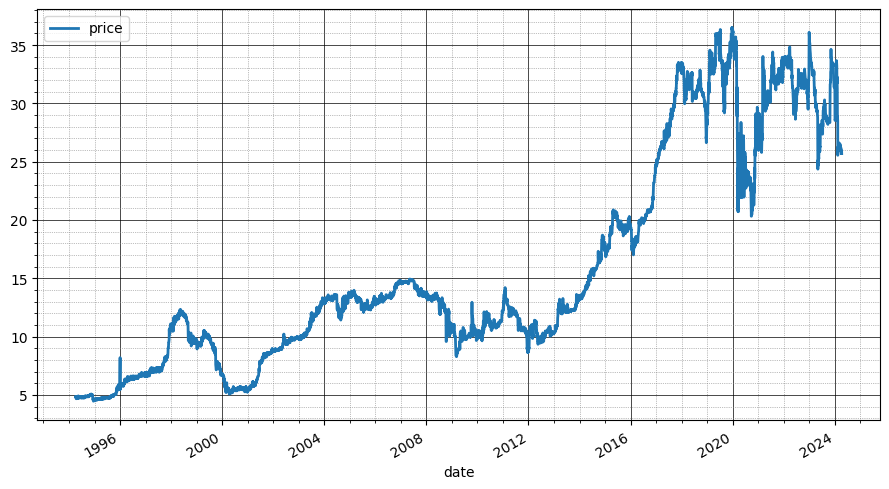

<Figure size 900x500 with 0 Axes>

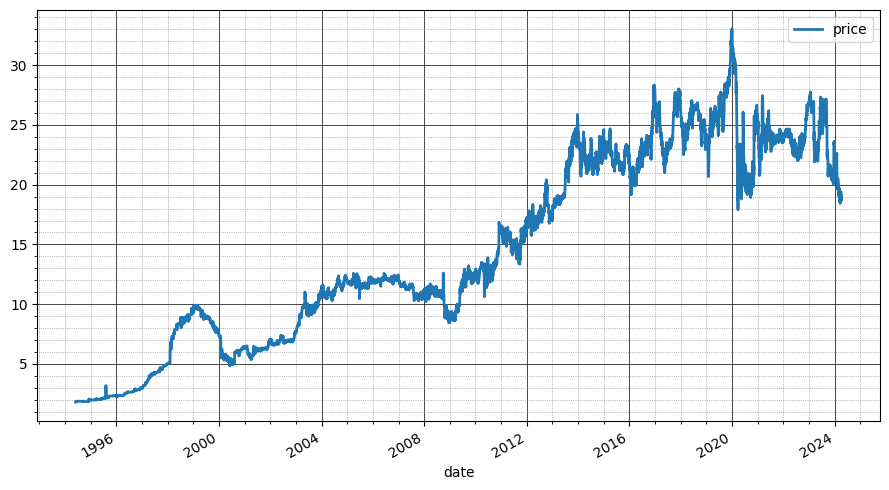

<Figure size 900x500 with 0 Axes>

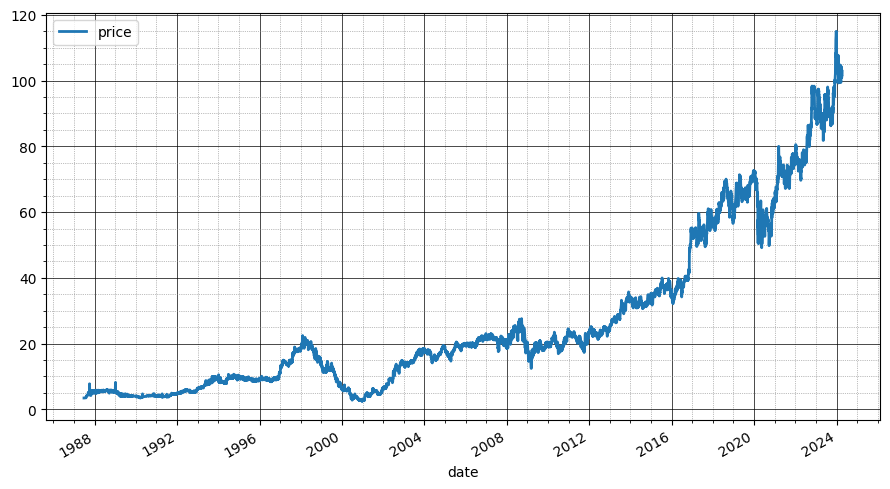

<Figure size 900x500 with 0 Axes>

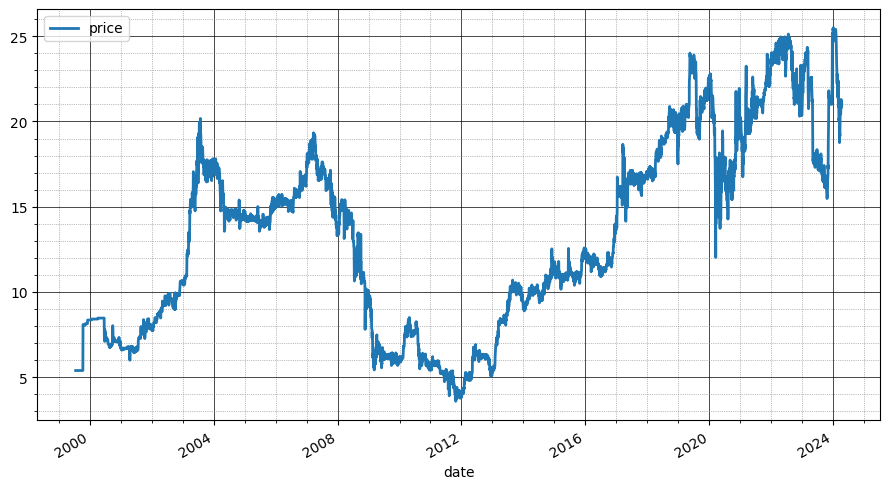

<Figure size 900x500 with 0 Axes>

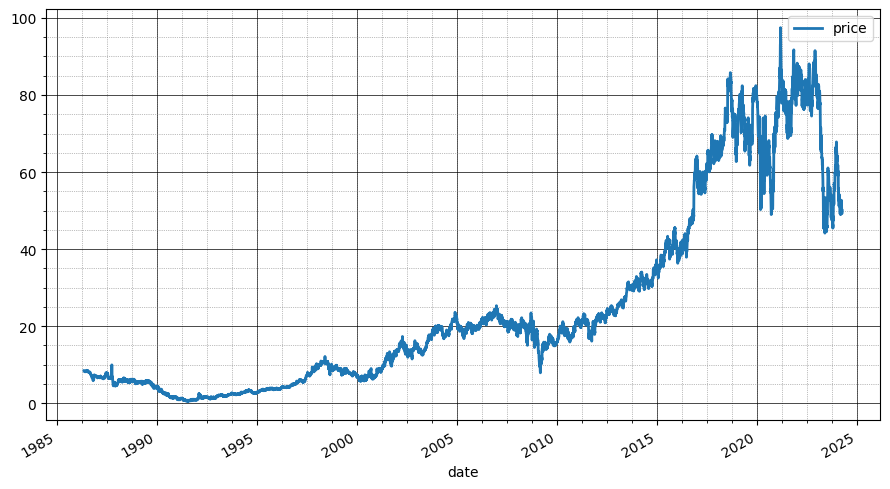

<Figure size 900x500 with 0 Axes>

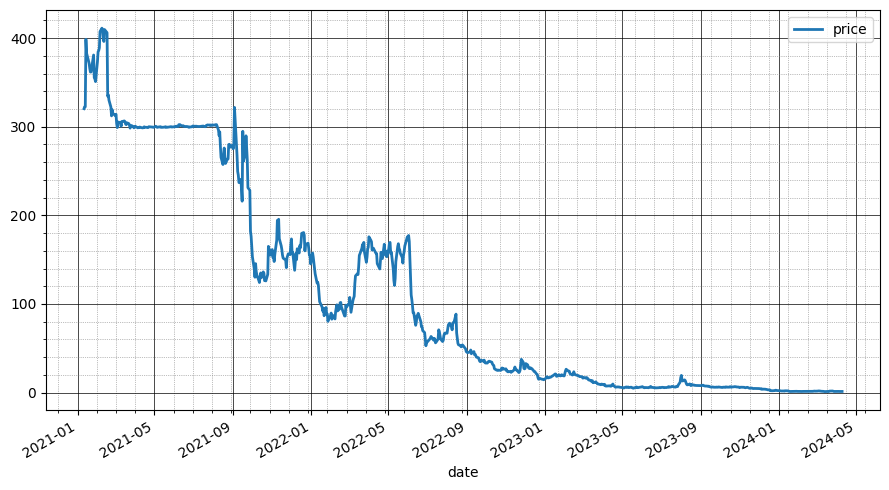

<Figure size 900x500 with 0 Axes>

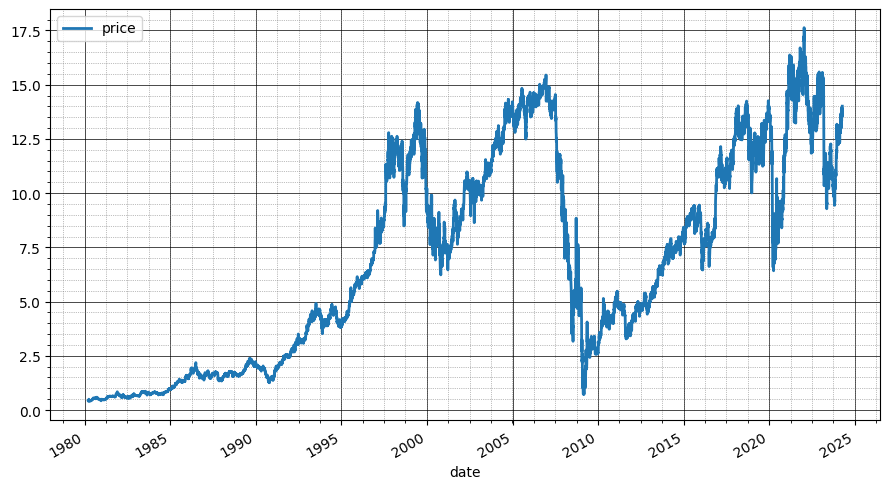

<Figure size 900x500 with 0 Axes>

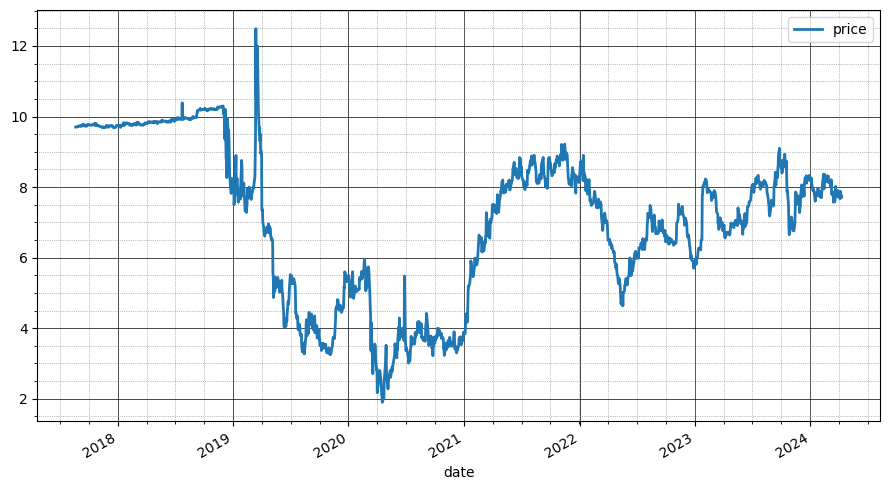

<Figure size 900x500 with 0 Axes>

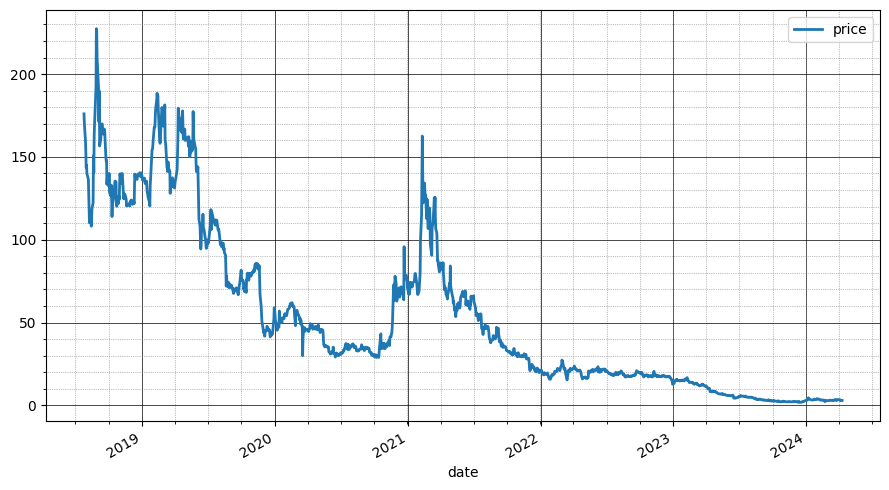

In [34]:
for symbol in high_returns.head(10).get_column(keys[1]):
    sub = cleaner_wo_weekends.filter(pl.col(keys[1]) == symbol).select(keys[0], 'price')
    plot_ts(sub, keys[0])

<Axes: >

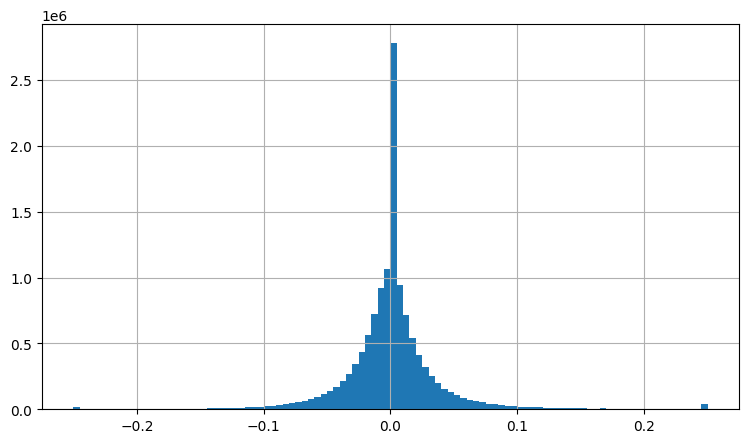

In [35]:
returns.to_pandas()['return'].clip(-0.25, 0.25).hist(bins=100)

## Is there good data?

In [36]:
stats = (
    cleaner_wo_weekends
    .with_columns(
        pl.col('price').pct_change().over(keys[1]).alias('return'),
        pl.col('price').rolling_mean(window_size=225 // 12).over(keys[1]).alias('mean')
    )
    .with_columns(pl.col('price') - pl.col('mean'))
    .group_by(keys[1])
    .agg([
        pl.col('price').std().alias('variance'),
        pl.col('return').abs().max().alias('max_return'),
        pl.col('price').null_count().alias('null_count')
    ])
)
okk = (
    stats
    .filter(pl.col('variance') < 2)
    .filter(pl.col('max_return') < 1)
    .sort('variance', 'max_return', 'null_count')
)
okk

shape: (2_372, 4)
┌────────┬──────────┬────────────┬────────────┐
│ symbol ┆ variance ┆ max_return ┆ null_count │
│ ---    ┆ ---      ┆ ---        ┆ ---        │
│ str    ┆ f64      ┆ f64        ┆ u32        │
╞════════╪══════════╪════════════╪════════════╡
│ PGYWW  ┆ 0.0      ┆ 0.0        ┆ 17         │
│ LIFWW  ┆ 0.002763 ┆ 0.869231   ┆ 17         │
│ INAQW  ┆ 0.014311 ┆ 0.183041   ┆ 17         │
│ HSPO   ┆ 0.019741 ┆ 0.013346   ┆ 17         │
│ ISRL   ┆ 0.020694 ┆ 0.009699   ┆ 17         │
│ …      ┆ …        ┆ …          ┆ …          │
│ ALVR   ┆ 1.983648 ┆ 0.671674   ┆ 17         │
│ ACON   ┆ 1.989893 ┆ 0.779661   ┆ 17         │
│ CRNX   ┆ 1.989992 ┆ 0.633062   ┆ 17         │
│ CALT   ┆ 1.996385 ┆ 0.348828   ┆ 17         │
│ TIGO   ┆ 1.997841 ┆ 0.233161   ┆ 17         │
└────────┴──────────┴────────────┴────────────┘

<Figure size 900x500 with 0 Axes>

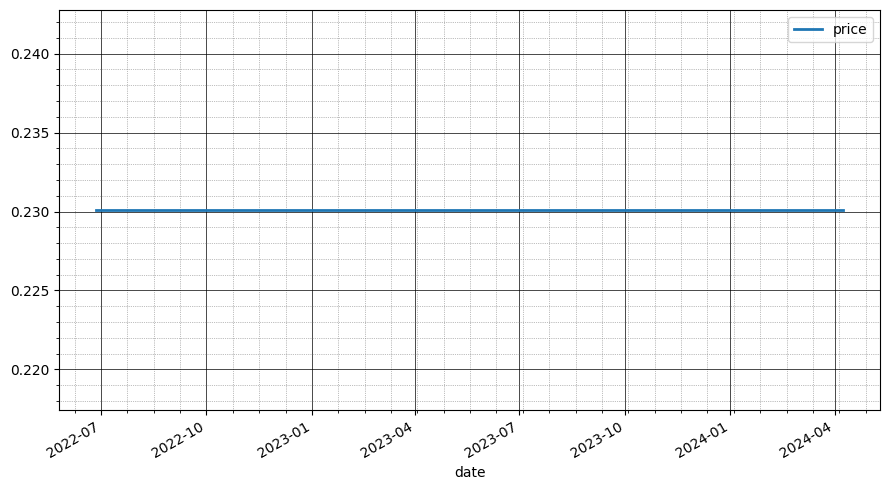

<Figure size 900x500 with 0 Axes>

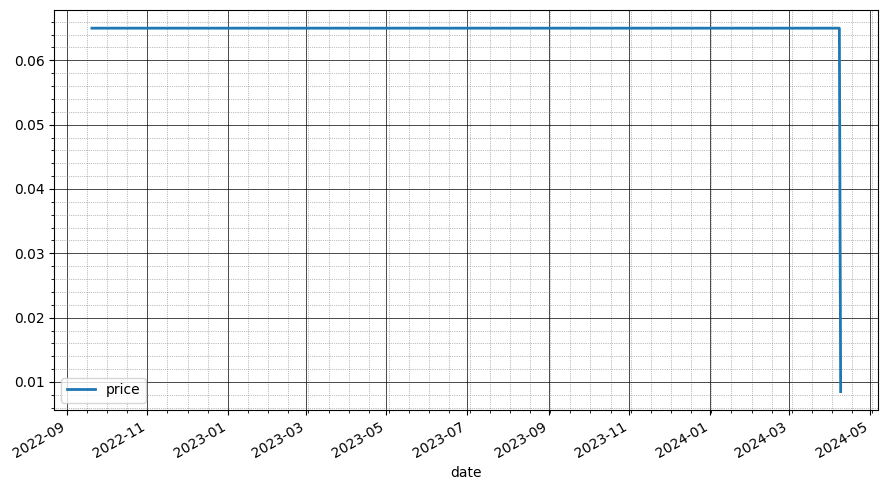

<Figure size 900x500 with 0 Axes>

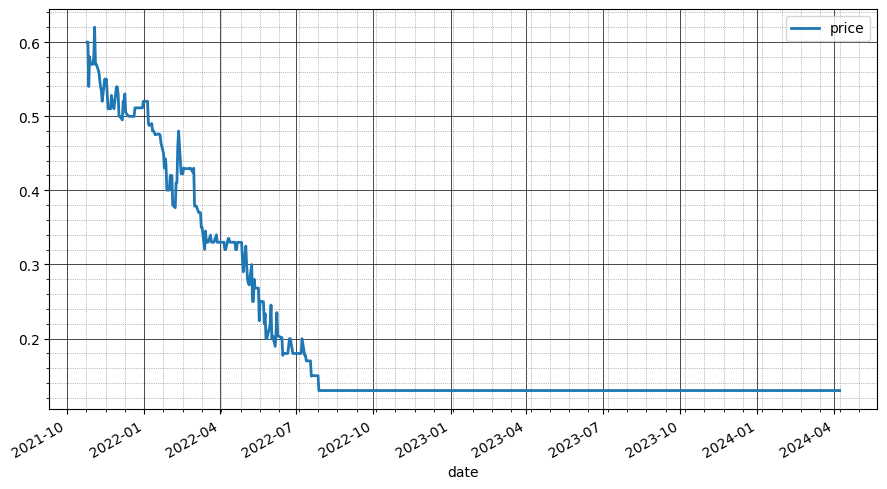

<Figure size 900x500 with 0 Axes>

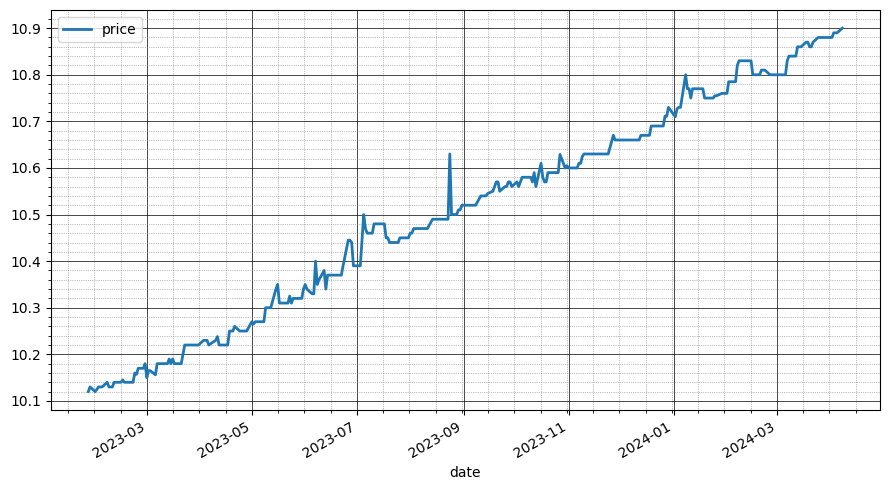

<Figure size 900x500 with 0 Axes>

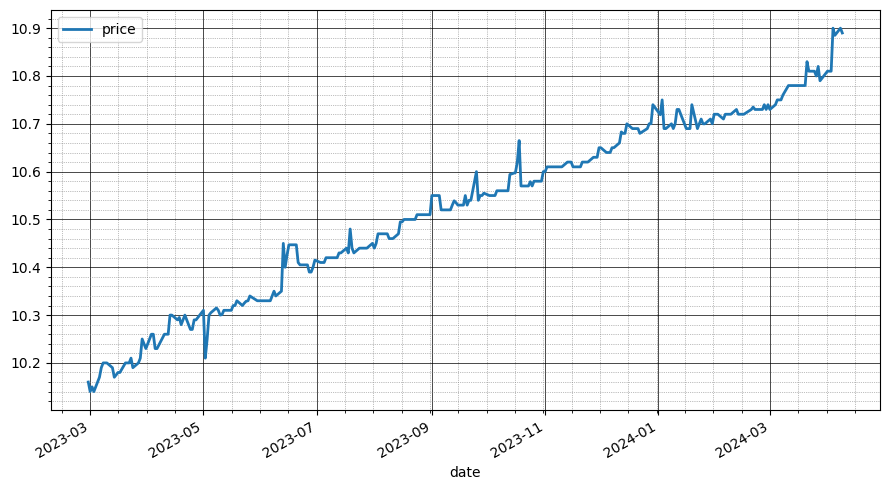

<Figure size 900x500 with 0 Axes>

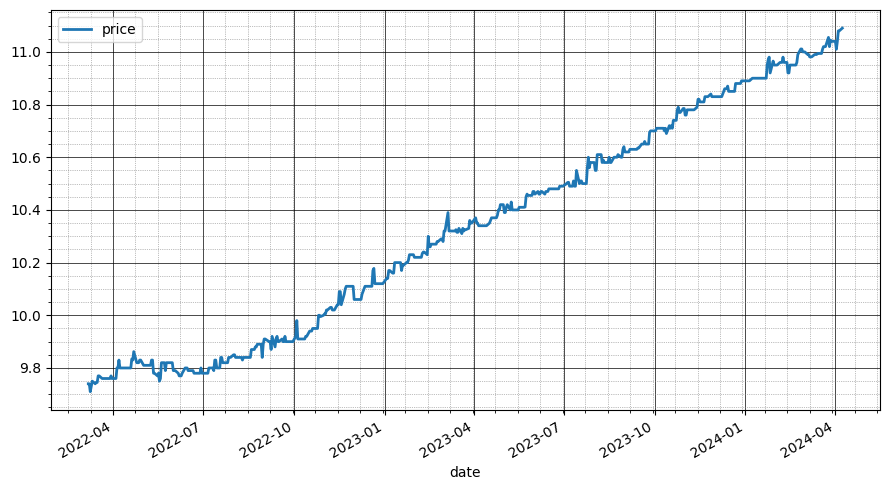

<Figure size 900x500 with 0 Axes>

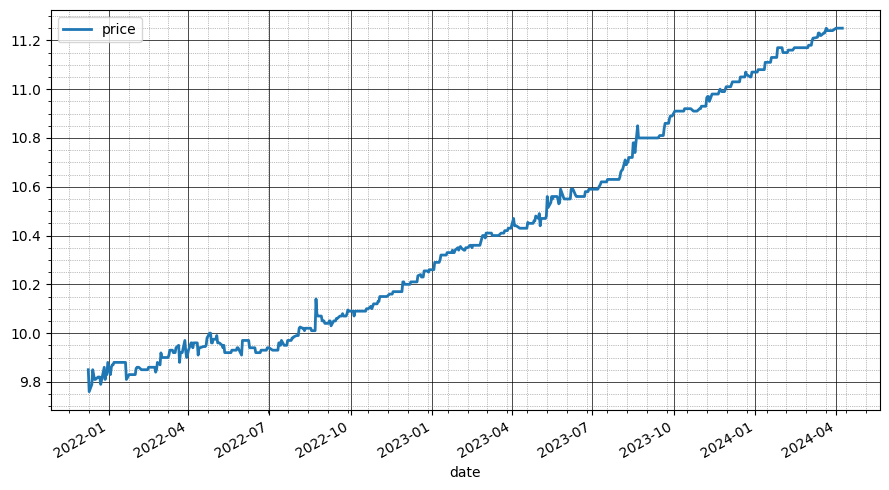

<Figure size 900x500 with 0 Axes>

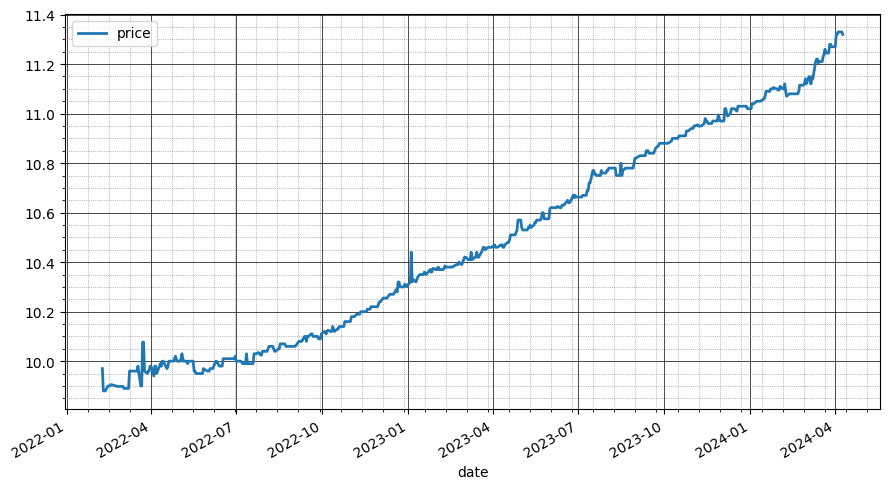

<Figure size 900x500 with 0 Axes>

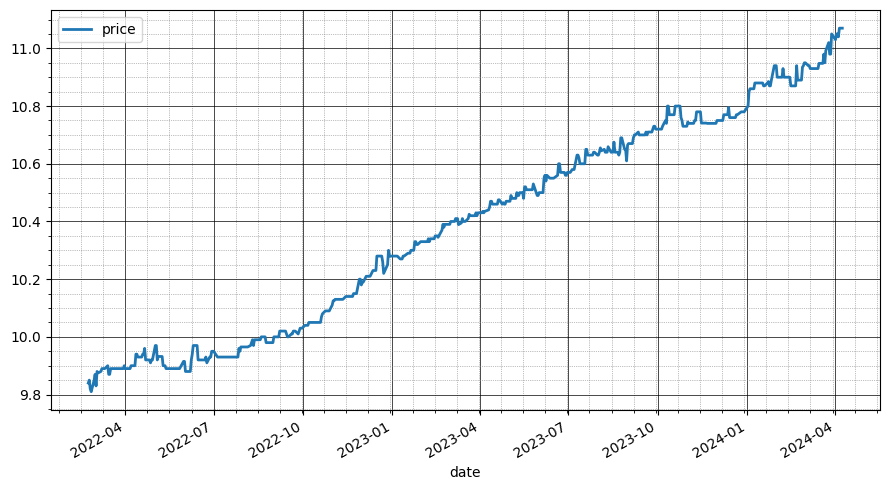

<Figure size 900x500 with 0 Axes>

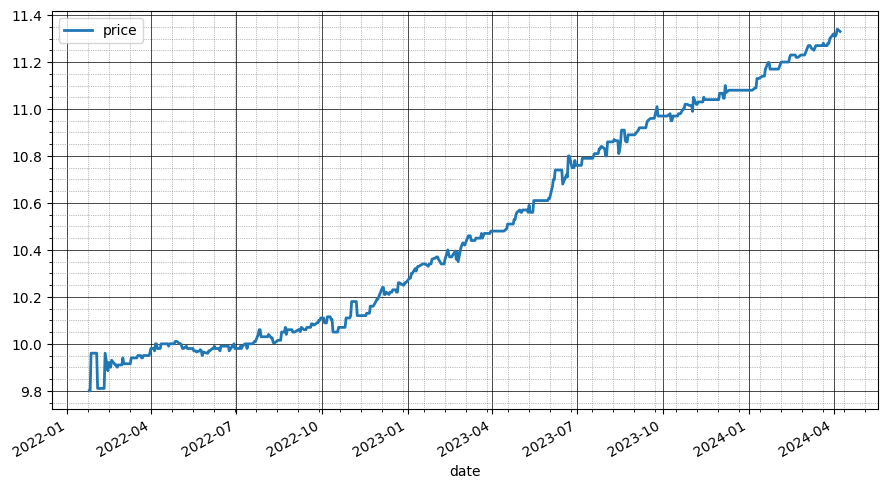

In [37]:
for symbol in okk.head(10).get_column(keys[1]):
    sub = cleaner_wo_weekends.filter(pl.col(keys[1]) == symbol).select(keys[0], 'price')
    plot_ts(sub, keys[0])

<Figure size 900x500 with 0 Axes>

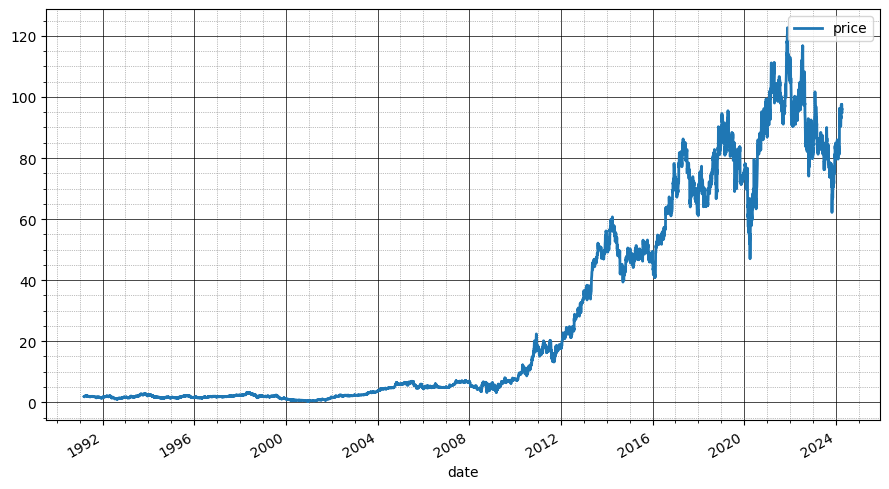

<Figure size 900x500 with 0 Axes>

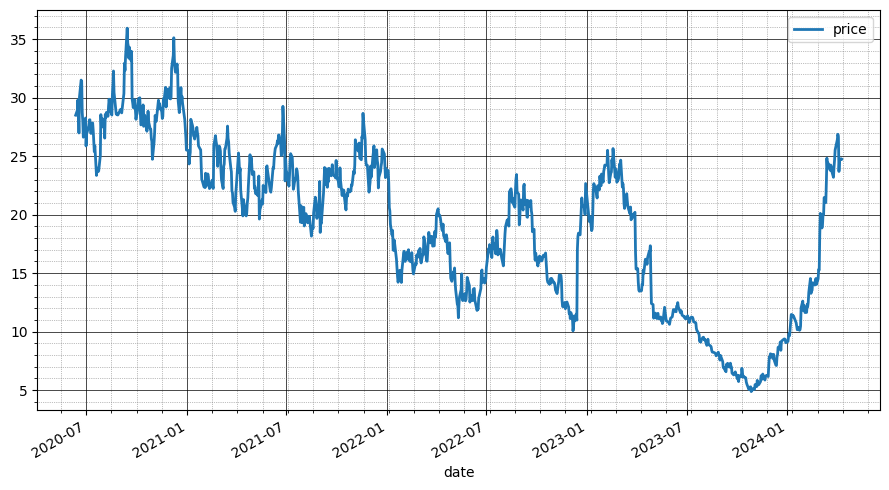

<Figure size 900x500 with 0 Axes>

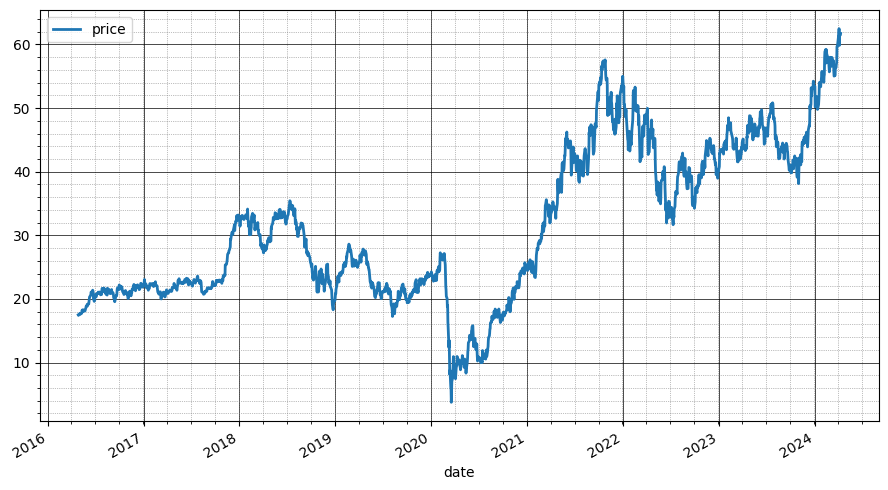

<Figure size 900x500 with 0 Axes>

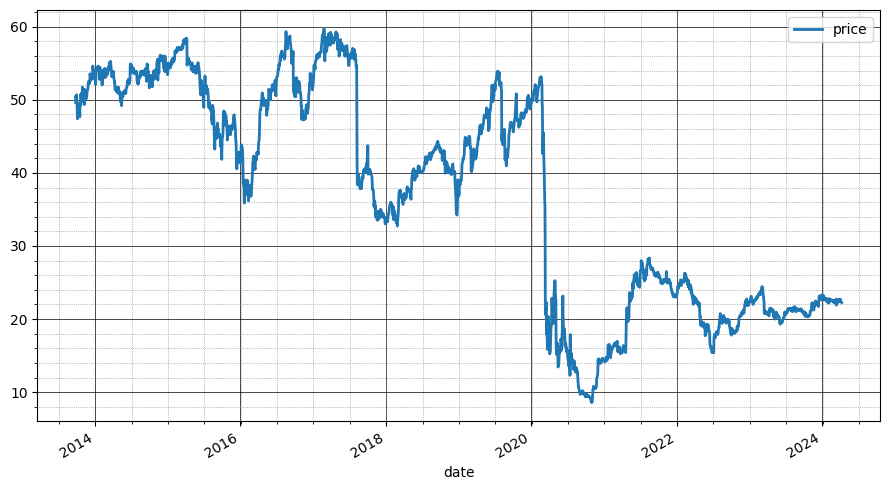

<Figure size 900x500 with 0 Axes>

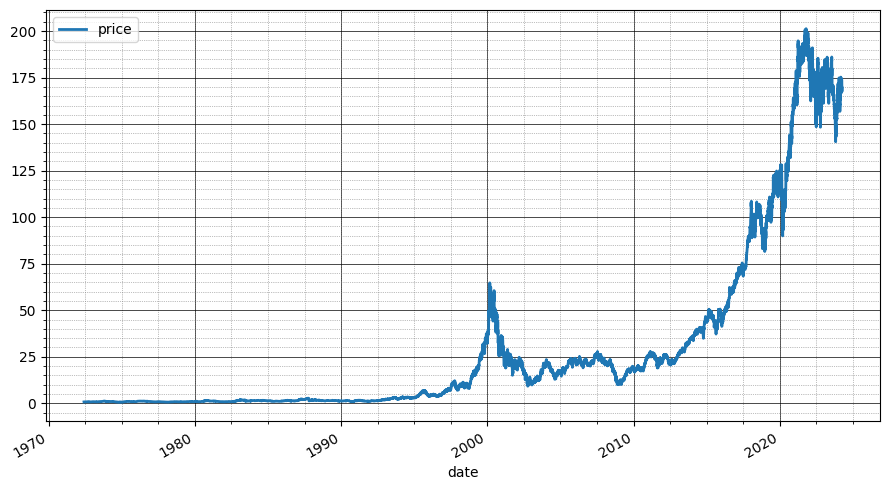

<Figure size 900x500 with 0 Axes>

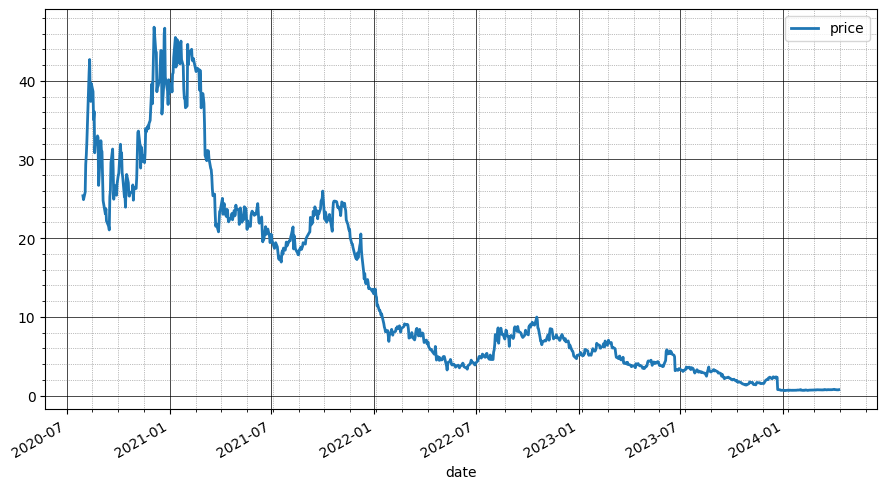

<Figure size 900x500 with 0 Axes>

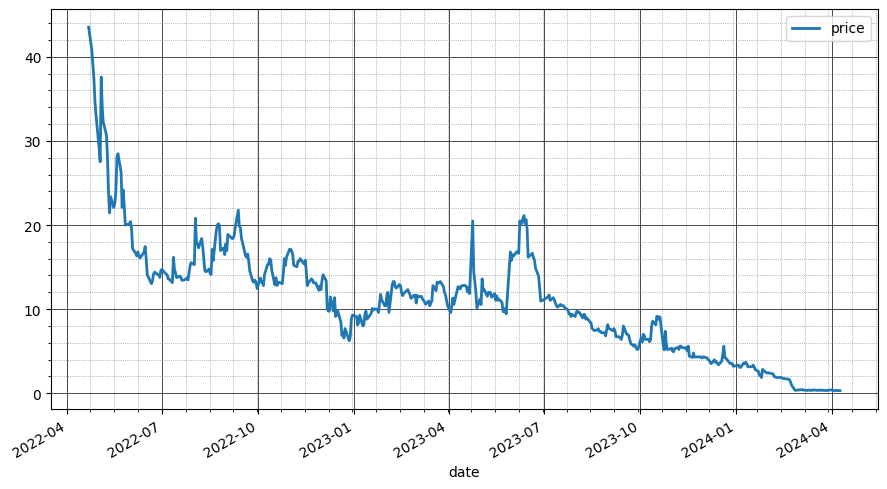

<Figure size 900x500 with 0 Axes>

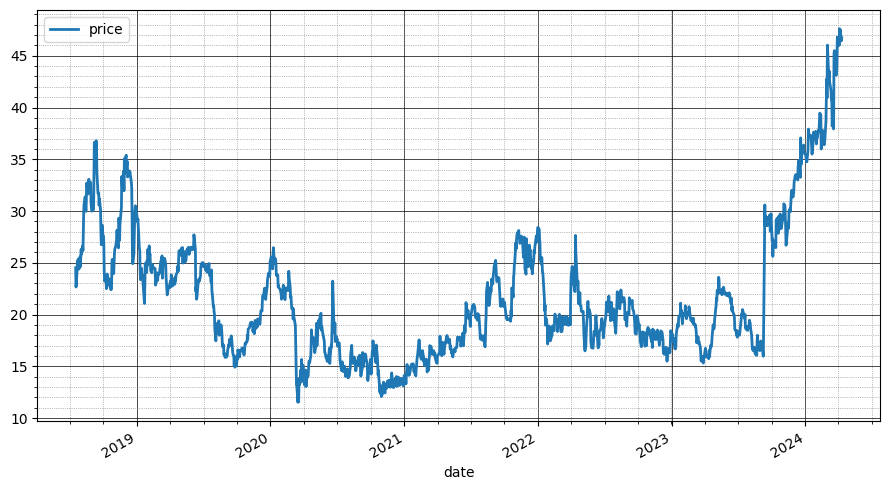

<Figure size 900x500 with 0 Axes>

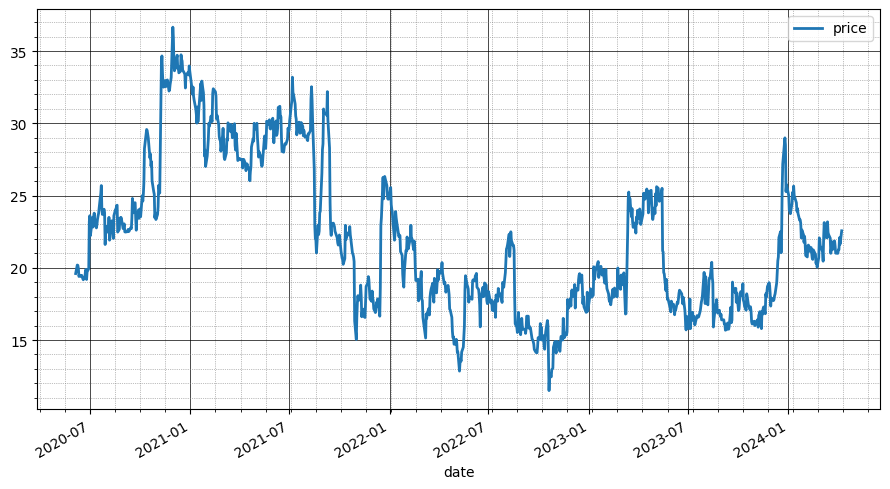

<Figure size 900x500 with 0 Axes>

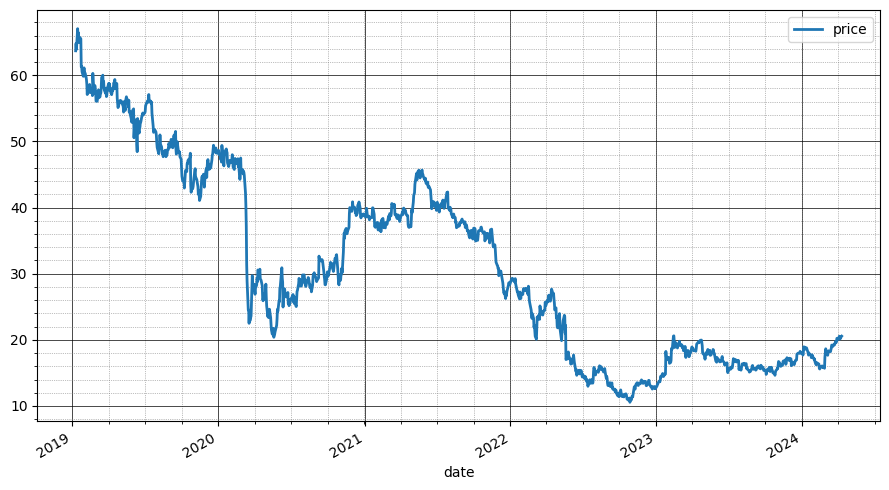

In [38]:
for symbol in okk.tail(10).get_column(keys[1]):
    sub = cleaner_wo_weekends.filter(pl.col(keys[1]) == symbol).select(keys[0], 'price')
    plot_ts(sub, keys[0])

## Back to _wo_weekends and save

In [39]:
symbols = cleaner_wo_weekends.select(pl.col('symbol').unique())
cleaner = symbols.join(cleaner, on='symbol', how='inner').select(*keys, pl.exclude(keys))
cleaner = cleaner.with_columns(pl.col('volume') * pl.col('price'))

In [40]:
cleaner.select(pl.col('date').n_unique(), pl.col('symbol').n_unique())

shape: (1, 2)
┌───────┬────────┐
│ date  ┆ symbol │
│ ---   ┆ ---    │
│ u32   ┆ u32    │
╞═══════╪════════╡
│ 15674 ┆ 4094   │
└───────┴────────┘

In [41]:
cleaner.write_parquet('prices_yf.parquet')

In [42]:
cleaner_wo_weekends.select(pl.col('date').n_unique(), pl.col('symbol').n_unique())

shape: (1, 2)
┌───────┬────────┐
│ date  ┆ symbol │
│ ---   ┆ ---    │
│ u32   ┆ u32    │
╞═══════╪════════╡
│ 15674 ┆ 4094   │
└───────┴────────┘

In [43]:
# cleaner_wo_weekends.write_parquet('cleaner_wo_weekends.parquet')